<a href="https://colab.research.google.com/github/SirSirocco/DataScience_2025_1/blob/colab/plan_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDÊNCIAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from itertools import product
from math import floor, sqrt
from typing import Union
from sklearn.base import BaseEstimator, clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy import stats
from xgboost import XGBRegressor

# FUNÇÕES

## _Ad hoc_

### Constantes

In [ ]:
"""
Define classes vazias (com "pass") que servirão de namespaces, isto é, de prefixos que identificam o
escopo de visualização de variáveis.
"""

# Dados do Plano de Experimentação
class ExperimentPlan:
    pass
exp = ExperimentPlan()
exp.pre = "pre_processing"              # Pré-processamento
exp.rf = "RandomForestRegressor"        # Random Forest
exp.xgb = "XGBRegressor"                # XGBoost
exp.all = "all"                         # Todos os modelos considerados simultaneamente

exp.cv_folds = [2, 3, 5]                # Números de K-folds usados na Validação Cruzada
exp.fs_scenarios = ["na", "stateless"]  # Cenários de seleção de características
exp.metrics = ["mae", "mse", "r2"]      # Métricas usadas na Validação Cruzada
exp.models = [exp.rf, exp.xgb]          # Algoritmos usados

# Colunas do dataset
class Key():
    pass
key = Key()
key.cs = "case"
key.cv_metric = "cv_metric"
key.feat = "feature"
key.fs = "col_rem"
key.imp = "importance"
key.model = "algorithm"
key.norm = "normalization"
key.out = "outliers"
key.pca = "pca"

# Parâmetros dos modelos
key.max_depth = "max_depth"
key.n_estimators = "n_estimators"

# Raízes
class Radix:
    pass
rad = Radix()
rad.avg = "cv_avg"              # Indica desempenho média na Validação Cruzada
rad.cv = "_cv_"                 # Indica Validação Cruzada
rad.fold = "cv_fold"            # Indica desempenho em um certo fold da Validação Cruzada
rad.test = "best_model_test"    # Indica teste
rad.train = "cv_avg"            # Indica conjunto de treino

# Máscaras
"""
Indica padrões a serem obtidos da chave identificadora de caso no plano de
experimentação.
"""
class Mask:
    pass
mask = Mask()
mask.fs = "FS={}"   # Máscara de Feature Selection
mask.cv = "CV={}"   # Máscara de Cross Validation

# Formatação
class Format:
    pass
fmt = Format()
fmt.test = "Teste"
fmt.train = "Treino"
fmt.map_metric = {
    "mae":  "MAE (Ha)",
    "mse":  "MSE (Ha²)",
    "r2":   "R²",
}
fmt.map_param = {
    "n_estimators": "Número de estimadores",
    "max_depth": "Profundidade máxima",
}

### Funções Propriamente Ditas

In [ ]:
def normalize_df_exp_plan_cv(df_exp_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Converte o DataFrame de resultados de validação cruzada de formato “wide” para “long”
    criando uma linha por métrica de CV e renomeando colunas para tornar diferentes
    esquemas comparáveis.

    :param df_exp_plan: DataFrame original com resultados de validação cruzada e teste,
        onde cada métrica pode estar em diferentes colunas prefixadas (ex.: "mae_cv_fold1",
        "mse_cv_fold3, etc.).
    :type df_exp_plan: pd.DataFrame
    :returns: DataFrame “normalizado” onde:

        - Cada linha corresponde a uma única métrica de CV (coluna `key.cv_metric`)
        - Colunas de valor (folds e teste) foram renomeadas removendo o prefixo da métrica
        - As demais colunas originais são mantidas para identificação de cenário

    :rtype: pd.DataFrame
    """
    RENAMING = [x for x in df_exp_plan.columns if rad.cv in x or rad.test in x]
    dfs = list()

    # Normaliza DataFrame, gerando uma linha por métrica usada na validação cruzada
    for cv_metric in exp.metrics:
        # Remove informações da C.V. das outras métricas
        dropping = [x for x in df_exp_plan.columns if not x.startswith(cv_metric) and x in RENAMING]
        df = df_exp_plan.drop(columns=dropping)

        # Retira prefixo com nome da métrica
        mapping_renaming = {x: x.removeprefix(f"{cv_metric}_") for x in RENAMING}
        df = df.rename(columns=mapping_renaming)

        # Indica métrica representada
        df[key.cv_metric] = cv_metric
        dfs.append(df)

    return pd.concat(dfs, axis=0)

def get_coefs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extrai coeficientes (importâncias de features) armazenados como multiline strings em um DataFrame.

    Lê cada linha do DataFrame de entrada, interpreta o campo de importâncias (em formato texto)
    como múltiplas linhas "\<feature\> \<value\>" e converte em um novo DataFrame de três colunas:
    - key.feat: nome da feature
    - key.imp: valor da importância (float)
    - key.model: nome do modelo associado

    :param df: DataFrame contendo, em cada linha, uma string de importâncias em df[key.imp]
        e o nome do modelo em df[key.model].
    :type df: pd.DataFrame
    :returns: DataFrame com uma linha por feature-model, contendo colunas:\n
        - key.feat (`str`): nome da feature\n
        - key.imp (`float`): importância da feature\n
        - key.model (`str`): nome do modelo\n
    :rtype: pd.DataFrame
    """
    coef_rows = list()

    for _, row in df.iterrows():
        model_name = row[key.model]

        # Converter a string do campo de importância em uma Series
        lines = str(row[key.imp]).splitlines()
        for line in lines:
            if line.strip() == "" or line.startswith("dtype:"): # Linha sem valor da série
                continue

            try:
                feature, value = line.strip().split()
                coef_rows.append({
                    key.feat: feature,
                    key.imp: float(value),
                    key.model: model_name
                })

            except ValueError:
                continue # Linha mal formatada, ignora

    return pd.DataFrame(coef_rows)

def get_train_metric_series(df_exp_plan: pd.DataFrame, metric: str) -> pd.Series:
    """
    Agrupa e concatena os valores de treino obtidos nos folds da validação cruzada de uma dada métrica em uma única série.

    :param df_exp_plan: DataFrame contendo colunas de resultados de validação cruzada,
                        onde cada coluna de treino de fold segue o padrão
                        f\"{metric}_...{rad.fold}...\".
    :type df_exp_plan: pd.DataFrame
    :param metric: Nome da métrica usada no CV (por exemplo, "mae", "mse", "r2").
    :type metric: str
    :returns: Série pandas contendo, em sequência, todos os valores dos folds de treino
              para a métrica especificada, com entradas NAs removidas.
    :rtype: pd.Series
    :raises KeyError: se não houver nenhuma coluna correspondente à métrica.
    """
    # Obtém colunas da validação cruzada
    train_cols = [col for col in df_exp_plan.columns if rad.fold in col and metric in col]

    # Obtém séries a partir das colunas
    series = list()
    for col in train_cols:
        series.append(df_exp_plan[col])

    # Concatena
    concatted = pd.concat(series, ignore_index=True)

    # Remove NAs
    concatted = concatted.dropna()

    return concatted

def get_test_metric_series(df_exp_plan: pd.DataFrame, metric):
    """
    Agrupa e concatena os valores de teste de uma dada métrica em uma única série.

    :param df_exp_plan: DataFrame contendo colunas de resultados de teste, que seguem o padrão
                        f"<prefixo_de_teste>_<metric>" (rad.test + metric).
    :type df_exp_plan: pd.DataFrame
    :param metric: Nome da métrica usada no sufixo das colunas de teste
                   (por exemplo, "mae", "mse", "r2").
    :type metric: str
    :returns: Série pandas contendo, em sequência, todos os valores de teste
              para a métrica especificada, com entradas NAs removidas.
    :rtype: pd.Series
    :raises ValueError: se nenhuma coluna de teste correspondente for encontrada.
    """
    # Obtém colunas de teste
    test_cols = [col for col in df_exp_plan.columns if rad.test in col and col.endswith(metric)]

    # Obtém séries a partir das colunas
    series = list()
    for col in test_cols:
        series.append(df_exp_plan[col])

    # Concatena
    concatted = pd.concat(series, ignore_index=True)

    # Remove NAs
    concatted = concatted.dropna()

    return concatted

## Recriação do Plano de Experimentação

### Utilitário

In [ ]:
def dict_combine(dictionary: dict) -> list:
    """
    Gera todas as combinações possíveis entre os valores de um dicionário de listas,
    retornando uma lista de dicionários com cada combinação única.

    :param dictionary: Dicionário em que cada chave está associada a uma lista de valores possíveis.
                       Os valores devem ser iteráveis (como listas ou tuplas) e de mesmo comprimento.

    :return: Lista contendo dicionários. Cada dicionário representa uma combinação possível
             entre os valores das listas fornecidas no dicionário original. As chaves são mantidas,
             e os valores correspondem a uma das combinações do produto cartesiano.
    """
    # Passo 1: Obtemos as chaves do dicionário (ex: ["key1", "key2"])
    keys = list(dictionary.keys())

    # Passo 2: Obtemos os valores associados a cada chave (listas de possibilidades)
    # Exemplo: [["a", "b", "c"], ["d", "e", "f"]]
    values = list(dictionary.values())

    # Passo 3: Calculamos o produto cartesiano dessas listas de valores
    # Isso gera todas as combinações possíveis, como ("a", "d"), ("a", "e"), ..., ("c", "f")
    combinations = product(*values)  # Asterisco faz o desempacotamento dos elementos de values

    # Passo 4: Para cada combinação, associamos os valores às suas respectivas chaves
    # Isso é feito com a função zip, e transformamos o resultado em um dicionário
    # Resultado final: uma lista de dicionários, cada um representando uma combinação possível
    return [dict(zip(keys, combo)) for combo in combinations]

def key_part_build(attr, val, separator: str = "=") -> str:
    return separator.join([str(attr).upper(), str(val).lower()])

def key_build(key_parts: list[str], separator: str = "|") -> str:
    return separator.join(key_parts)

def key_build_from_params(params: dict[str]):
    parts = [key_part_build(k, v) for k, v in params.items()]
    return key_build(parts)

def series_combine(list_series: list[pd.Series], operations: list[-1, 1]):
    """
    Combina uma lista de séries aplicando multiplicações e divisões de acordo com a lista de operações.

    Args:
        list_series (list of pd.Series): Lista de séries a combinar.
        operations (list of int): Lista de 1 e -1, indicando multiplicação (1) ou divisão (-1).

    Returns:
        pd.Series: Série resultante da combinação.
    """
    if len(list_series) != len(operations):
        raise ValueError("'list_series' e 'operations' devem ter o mesmo tamanho.")

    # Inicializa com uma série de 1s do mesmo índice da primeira série
    result = pd.Series(1.0, index=list_series[0].index)

    for series, op in zip(list_series, operations):
        if op == 1:
            result *= series  # multiplica se op for 1
        elif op == -1:
            result /= series  # divide se op for -1
        else:
            raise ValueError("A lista de operações só pode conter 1 ou -1.")

    return result

def series_normalize(series: pd.Series, scaler, series_name: str) -> pd.Series:
    series_copy = series.copy()
    array = scaler.fit_transform(series_copy.values.reshape(-1, 1))
    return pd.Series(array.squeeze(), name=series_name)

### Pré-processamento

In [ ]:
def subs_outliers(df: pd.DataFrame, columns: list[str], view: bool = False) -> pd.DataFrame:
    """
    Substitui outliers pela média. Se view for True, exibe
    dois gráficos para cada coluna: antes e depois da mudança.
    """

    # Guarda resultado anterior
    df_before = df.copy()

    for column in columns:
        # Obtém quartis 1 e 3
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)

        # Obtém IQR (Intervalo Interquartílico)
        iqr = q3 - q1

        """
        Outlier se em (-inf, Q1 - 1.5 * IQR) ou (Q3 + 1.5 * IQR, +inf).
        Subsititui outliers por NA ('not available') segundo método IQR (InterQuartile Range).
        """
        df.loc[(df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr), column] = pd.NA

        # Substitui NAs pela média
        df[column] = df[column].fillna(df[column].mean())

    if view:
        for column in columns:
            # Exibe resultado inicial
            plt.boxplot(df_before[column])
            plt.title(f"ANTES: {column}")
            plt.show()

            # Exibe novo resultado
            plt.boxplot(df[column])
            plt.title(f"DEPOIS: {column}")
            plt.show()

    return df

### Validação

In [ ]:
def is_valid_col_selection(col_selection: dict) -> bool:
    return col_selection is not None

def is_valid_series(se: pd.Series) -> bool:
    return se is not None and (not se.empty) and se.notnull().all() and pd.api.types.is_numeric_dtype(se)

### Validação Cruzada

In [ ]:
def cross_val(model: BaseEstimator,
              X: pd.DataFrame,
              y: pd.Series,
              folds: int = 5,
              metric: str = "r2",
              shuffle: bool = True,
              random_state: int = None) -> tuple[list, list]:
    """
    Realiza validação cruzada utilizando K-Fold para treinar e avaliar um modelo,
    com base em uma métrica de desempenho fornecida.

    O modelo é clonado para cada divisão dos dados, garantindo independência entre os folds.

    :param model: Estimador compatível com o Scikit-learn (deve implementar os métodos `fit` e `predict`).
    :param X: Conjunto de dados de entrada (features).
    :param y: Vetor alvo (target) correspondente às amostras em `X`.
    :param folds: Número de partições (folds) na validação cruzada. O padrão é 5.
    :param metric: Métrica de avaliação utilizada em cada fold.
                   Pode ser uma das opções: `"r2"`, `"mse"`, `"mae"`.
                   Se inválida, `"r2"` será usada como padrão.
    :param shuffle: Indica se os dados devem ser embaralhados antes da divisão em folds.
    :param random_state: Semente de aleatoriedade para reprodutibilidade. `None` implica aleatoriedade completa.

    :return: Tupla contendo:
             - lista de modelos treinados (um por fold)
             - lista de métricas correspondentes a cada fold
    """
    DICT_METRICS = {
        "r2":   r2_score,
        "mse":  mean_squared_error,
        "mae":  mean_absolute_error
    }
    models = list() # Salva modelos por fold
    metrics = list() # Salva resultados por fold
    metric_to_use = DICT_METRICS.get(metric, r2_score) # Define métrica a ser usada (padrão é coeficiente de determinação)

    # Define os índices que delimitam as partições
    kfolds = KFold(n_splits=folds, shuffle=shuffle, random_state=random_state)

    for train_index, test_index in kfolds.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        copy = clone(model) # Evita sobrescrição do modelo
        copy.fit(X_train, y_train)

        models.append(copy)
        metrics.append(metric_to_use(y_test, copy.predict(X_test))) # Calcula métrica

    return models, metrics

### Recriação Propriamente Dita

In [ ]:
# --- CONSTANTES SIMBÓLICAS ---
"""
Incluímos '_' ao início para evitar conflitos de nomes com o restante do código.
"""
# - Pré-processamento -
_COLUMN_REMOVAL = "col_rem"
_COLUMNS = "columns"
_NAME = "name"
_FEATURE_ENGINEERING = "feat_eng"
_OUTLIERS = "outliers"
_NORMALIZATION = "normalization"
_PCA = "pca"

PREFIXES = {
    _COLUMN_REMOVAL: "FS",
    _FEATURE_ENGINEERING: "FE",
    _OUTLIERS: "OUT",
    _NORMALIZATION: "NORM",
    _PCA: "PCA"
}

_ABSENT = "absent"
_TRUE = "true"
_FALSE = "false"

RADIXES = {
    _ABSENT: "na",
    _TRUE: "1",
    _FALSE: "0"
}

_X = "X"
_y = "y"
_PARAMS = "params"

# - Métricas -
_MAE = "mae"
_MSE = "mse"
_R2 = "r2"
DICT_METRICS = {
        _MAE: mean_absolute_error,
        _MSE: mean_squared_error,
        _R2:  r2_score,
}
_ALGORITHM = "algorithm"
_AVERAGE = "avg"
_BEST_MODEL = "best_model"
_CROSS_VAL = "cv"
_FOLD = "fold"
_IMPORTANCE = "importance"
_PRED = "y_pred"
_RESIDUAL = "residual"
_TEST = "test"

# FUNÇÕES
def apply_column_removal(df, X, y, col_selection, prefix, radixes):
    if is_valid_col_selection(col_selection):
        columns = col_selection[_COLUMNS]
        df = df.drop(columns=columns)
        key = key_part_build(prefix, col_selection[_NAME]) # Indica nome da seleção de colunas
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        columns = None

    return df, X, y, key, {_COLUMN_REMOVAL: columns}

def apply_feature_engineering(df, X, y, feat_eng, prefix, radixes):
    if is_valid_series(feat_eng):
        df = pd.concat([df, feat_eng], axis=1)
        key = key_part_build(prefix, feat_eng.name.lower) # Indica nome da característica
        feat_name = feat_eng.name
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        feat_name = None

    return df, X, y, key, {_FEATURE_ENGINEERING: feat_name}

def apply_outliers(df, X, y, out, prefix, radixes):
    if out:
        df = subs_outliers(df, df.columns, view=False)
        key = key_part_build(prefix, radixes[_TRUE])
    else:
        key = key_part_build(prefix, radixes[_FALSE])

    X = df.drop(columns=[y.name])
    y = df[y.name].squeeze() # Squeeze garante ser uma série

    return df, X, y, key, {_OUTLIERS: out}

apply_normalization_scaler = StandardScaler() # Guarda scaler para reuso
def apply_normalization(df, X, y, norm, prefix, radixes):
    if norm:
        X = pd.DataFrame(apply_normalization_scaler.fit_transform(X), columns=X.columns, index=X.index)
        key = key_part_build(prefix, radixes[_TRUE])
    else:
        key = key_part_build(prefix, radixes[_FALSE])

    return df, X, y, key, {_NORMALIZATION: norm}

def apply_pca(df, X, y, pca_n, prefix, radixes):
    if pca_n > 0: # Se for passado um número não positivo, entende-se que não há PCA
        key = key_part_build(prefix, pca_n)
        # Evita que componentes superem total de colunas, o que geraria redundância
        pca_n = min(len(X.columns), pca_n)

        pca_obj = PCA(n_components=pca_n)
        pca_arr = pca_obj.fit_transform(X)
        X_pca = pd.DataFrame(
            pca_arr,
            index=X.index,
            columns=[f"pc{i + 1}" for i in range(pca_n)]
        )
    else:
        key = key_part_build(prefix, radixes[_ABSENT])
        X_pca = X

    return df, X_pca, y, key, {_PCA: pca_n}

def get_best_model(metric, models, scores):
    DICT_CRITERIA = {
        _MAE: np.argmin,
        _MSE: np.argmin,
        _R2: np.argmax
    }
    best_index = DICT_CRITERIA[metric](scores)
    best_index = best_index[0] if isinstance(best_index, np.ndarray) else best_index
    return models[best_index]

def get_experiment_data(
        df: pd.DataFrame,
        target: str,
        random_state: int,
        col_selections: list[dict],
        features: list[pd.Series],
        outliers: list[bool],
        normalization: list[bool],
        pcas: list[int],
        model: BaseEstimator,
        params: dict,
        folds: list[int],
        metrics: list[str],
        test_size: float,
        log: bool = True) -> dict:
    """
    Executa toda a pipeline de experimentação: pré-processamento, cross-validation e avaliação em teste.

    :param df: DataFrame original contendo todas as variáveis preditoras e a coluna alvo.
    :type df: pd.DataFrame
    :param target: Nome da coluna em `df` que contém a variável alvo (y).
    :type target: str
    :param random_state: Semente para geração de números aleatórios (reprodutibilidade).
    :type random_state: int
    :param col_selections: Lista de dicionários que definem cenários de remoção de colunas.
    :type col_selections: list[dict]
    :param features: Lista de pd.Series ou configurações de engenharia de features a aplicar.
    :type features: list[pd.Series]
    :param outliers: Lista de flags boleanas indicando, para cada cenário, se deve remover outliers.
    :type outliers: list[bool]
    :param normalization: Lista de flags boleanas indicando se deve aplicar normalização.
    :type normalization: list[bool]
    :param pcas: Lista de inteiros indicando quantos componentes PCA usar em cada cenário.
    :type pcas: list[int]
    :param model: Estimador compatível com scikit-learn (implementa `fit`/`predict`).
    :type model: BaseEstimator
    :param params: Dicionário cujas chaves são nomes de hiper-parâmetros e valores são listas de possíveis valores.
    :type params: dict
    :param folds: Lista de inteiros indicando os valores de k para cross-validation.
    :type folds: list[int]
    :param metrics: Lista de nomes de métricas (strings) usadas em CV e teste.
    :type metrics: list[str]
    :param test_size: Proporção (0.0–1.0) do conjunto destinada a teste no `train_test_split`.
    :type test_size: float
    :param log: Se True, imprime no console o progresso de cada caso.
    :type log: bool
    :returns: Dicionário mapeando cada cenário (string chave) para outro dicionário com:

        - `_PARAMS`: parâmetros combinados de pré-processamento e modelo
        - `_IMPORTANCE`: feature importances do modelo treinado
        - `_CROSS_VAL`: pontuações médias e por fold na CV
        - `_TEST`: pontuações no conjunto de teste
        - `_PRED`: predições em teste
        - `_RESIDUAL`: resíduos (y_pred – y_true)

    :rtype: dict[str, dict[str, Any]]
    """
    np.random.seed(random_state) # Fixa semente aleatória
    df_original = df.copy()
    dict_pre = dict() # Armazena cenários de pré-processamento

    # ---- Pré-processamento ----
    for select, feat, out, norm, pca in product(col_selections, features, outliers, normalization, pcas):
        # Etapas de pré-processamento
        steps = [
            (apply_column_removal, select, PREFIXES[_COLUMN_REMOVAL]),
            (apply_feature_engineering, feat, PREFIXES[_FEATURE_ENGINEERING]),
            (apply_outliers, out, PREFIXES[_OUTLIERS]),
            (apply_normalization, norm, PREFIXES[_NORMALIZATION]),
            (apply_pca, pca, PREFIXES[_PCA]),
        ]

        key_parts = list()          # Armazena partes da chave que descreve o caso
        dict_params = dict()        # Armazena os parâmetros que compõem o caso
        df = df_original.copy()     # Copia DataFrame original para evitar sobrescrição
        X = df.drop(columns=[target])
        y = df[target]

        # Executa etapas
        for function, param, prefix in steps:
            df, X, y, key, update = function(df, X, y, param, prefix, RADIXES)
            key_parts.append(key)
            dict_params.update(update)

        key = key_build(key_parts)
        dict_pre[key] = {_X: X, _y: y, _PARAMS: dict_params}

    # ---- Execução de Modelos ----
    count = 0
    dict_cases = dict() # Armazena os casos de experimentação
    model_name = model.__class__.__name__

    # Percorre cenários de pré-processamento
    for base_key, pre_proc_params in dict_pre.items():
        try:
            # Inicio da nova chave formado pela chave do pré-processamento e nome do modelo
            name_key_part = key_part_build(_ALGORITHM, model_name)
            base_key = key_build([base_key, name_key_part])

            # Gera conjuntos de treino e de teste
            X = pre_proc_params[_X]
            y = pre_proc_params[_y]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

            # Gera cenários com base no número de folds e nos parâmetros do modelo
            for model_params, fold_num in product(dict_combine(params), folds):
                count += 1
                # dict_best_models = dict() # Armazena melhores modelos por métrica
                dict_scores_cross_val = dict() # Armazena pontuações médias da V.C. por métrica
                dict_scores_test = dict() # Armazena pontuações do teste por métrica
                dict_y_pred_test = dict() # Armazena predições do teste por métrica
                dict_residuals = dict()

                # Gera nova chave
                key_model_params = key_build_from_params(model_params)
                key_cv_part = key_part_build(_CROSS_VAL, fold_num)
                key_new = key_build([base_key, key_cv_part, key_model_params])

                model_case = clone(model)
                model_case.set_params(**model_params)

                for metric in metrics:
                    models_cross_val, scores_cross_val = cross_val(
                                        model_case,
                                        X_train,
                                        y_train,
                                        folds=fold_num,
                                        metric=metric,
                                        shuffle=True,
                                        random_state=random_state
                    )

                    # Guarda métricas por fold
                    for fold, score in zip(range(fold_num), scores_cross_val):
                        key_cross_val_folds = key_build([metric, _CROSS_VAL, _FOLD, str(fold)], separator="_")
                        dict_scores_cross_val[key_cross_val_folds] = score

                    # Computa métrica média
                    key_cross_val_avg = key_build([metric, _CROSS_VAL, _AVERAGE], separator="_")
                    dict_scores_cross_val[key_cross_val_avg] = np.mean(scores_cross_val)

                    # Escolhe melhor modelo
                    # key_cross_val_best_model = key_build([metric, _CROSS_VAL, _BEST_MODEL])
                    best_model = get_best_model(metric, models_cross_val, scores_cross_val)
                    # dict_best_models[key_cross_val_best_model] = best_model

                    # Computa métricas do melhor modelo
                    y_pred = best_model.predict(X_test) # Obtém predições
                    dict_residuals[metric] = y_pred - y_test # Obtém resíduos
                    dict_y_pred_test[metric] = y_pred
                    for internal_metric in metrics:
                        key_best_model_test = key_build([metric, _BEST_MODEL, _TEST, internal_metric], separator="_")
                        dict_scores_test[key_best_model_test] = DICT_METRICS[internal_metric](y_test, y_pred)

                # Gera dicionário de parâmetros
                combined_params = dict(pre_proc_params[_PARAMS]) # Garante que é um dicionário
                combined_params.update(model_params)
                combined_params[_ALGORITHM] = model_name

                # Extrai feature importance
                if hasattr(best_model, "feature_importances_"):
                    importances = pd.Series(best_model.feature_importances_, index=X.columns)

                elif hasattr(best_model, "get_booster"):
                    raw_importances = best_model.get_booster().get_score(importance_type="gain")
                    importances = pd.Series(raw_importances)

                    # Ajusta para X.columns se as chaves forem 'f0', 'f1', ...
                    if all(k.startswith("f") for k in importances.index):
                        importances.index = [X.columns[int(k[1:])] for k in importances.index]
                else:
                    importances = None  # Ou raise Exception se quiser abortar

                dict_cases[key_new] = {
                    _PARAMS: {**combined_params},
                    _IMPORTANCE: {_IMPORTANCE: importances},
                    _CROSS_VAL: dict_scores_cross_val,
                    _TEST: dict_scores_test,
                    _PRED: dict_y_pred_test,
                    _RESIDUAL: dict_residuals,
                }

                if log:
                    print(f"{count:4d} - Caso {key_new} finalizado.")

        except Exception as e:
            print(f"Erro ao processar caso {key_new}: {e}")

    return dict_cases

## Estatística

In [ ]:
def ci_mean_t_student(sample_series: pd.Series, confidence: float = 0.95) -> tuple[int, float, float, float]:
    """
    Calcula o intervalo de confiança para a média de uma amostra usando a distribuição t de Student.

    :param sample_series: Série contendo os valores da amostra (numéricos).
    :type sample_series: pd.Series
    :param confidence: Nível de confiança desejado (valor entre 0 e 1). Padrão é 0.95 (95%).
    :type confidence: float
    :returns: Tupla contendo:
        - **n** (*int*): Tamanho da amostra (número de observações não nulas).
        - **lower** (*float*): Limite inferior do intervalo de confiança.
        - **mean** (*float*): Média amostral.
        - **upper** (*float*): Limite superior do intervalo de confiança.
    :rtype: tuple[int, float, float, float]
    """
    a = np.array(sample_series) # Obtém amostra a partir da série
    n = len(a)                  # Número de elementos da amostra
    dof = n - 1                 # Graus de liberdade (degrees of freedom)

    # Computa estatísticas amostrais
    mean = a.mean()
    std = a.std(ddof = 1) # ddof (delta degrees of freedom) = 1 implica que dividirá por n - 1 no cálculo do desvio padrão

    # Usa a t de Student, porque se deseja obter a média sem o conhecimento do desvio padrão
    epsilon = (std / sqrt(n)) * stats.t.ppf((1.0 + confidence) / 2.0, dof)

    return n, mean - epsilon, mean, mean + epsilon

def ftest_ind(a: pd.Series, b: pd.Series, alternative: str = "two-sided") -> tuple[float, float]:
    """
    Calcula a estatística e o p-valor de um teste F de Fisher-Snedecor de razão entre variâncias de duas amostras. Função implementada no estilo
    do módulo stats do SciPy.

    :param a: Primeira amostra de dados.
    :type a: pd.Series
    :param b: Segunda amostra de dados.
    :type b: pd.Series
    :param alternative: Tipo de hipótese alternativa. Pode ser:\n
        - ``two-sided``: `var_a / var_b != 1`\n
        - ``greater``: `var_a / var_b > 1`\n
        - ``less``: `var_a / var_b < 1`\n
        :type alternative: str
    :returns: Estatística de teste e p-valor.
    :rtype: tuple[float, float]
    :raises ValueError: Se ``alternative`` não for um dos valores permitidos.
    """
    # Remove NaNs
    x = a.dropna()
    y = b.dropna()

    # Tamanhos e variâncias (amostrais, delta degrees of freedom (ddof) = 1)
    n1, n2 = x.size, y.size
    var1, var2 = x.var(ddof=1), y.var(ddof=1)
    dof1, dof2 = n1 - 1, n2 - 1

    # Estatística F de teste
    f_stat = var1 / var2

    # P-valor
    match alternative:
        case "two-sided":
            p_lower = stats.f.cdf(f_stat, dof1, dof2)
            p_upper = stats.f.sf(f_stat, dof1, dof2)
            pval = 2.0 * min(p_lower, p_upper)

            """
            Garante trucamento para 1.0 (valor máximo do p-valor), em caso de
            erros ocasionados pela imprecisão de operações com ponto flutuante.
            """
            pval = min(pval, 1.0)

        case "greater":
            pval = stats.f.sf(f_stat, dof1, dof2)

        case "less":
            pval = stats.f.cdf(f_stat, dof1, dof2)

        case _:
            raise ValueError('alternative deve ser "two-sided", "greater" ou "less"')

    return f_stat, pval

def add_coef_var_column(df: pd.DataFrame,
                        col_values: list[str],
                        col_name: str,
                        ddof: int = 1) -> pd.DataFrame:
    """
    Adiciona uma coluna ao DataFrame com o coeficiente de variação calculado
    a partir de um conjunto de colunas numéricas.

    :param df: DataFrame original contendo as colunas para cálculo.
    :type df: pd.DataFrame
    :param var_col_name: Nome da nova coluna que receberá o coeficiente de variação.
    :type var_col_name: str
    :param var_col_values: Lista de nomes das colunas numéricas usadas no cálculo.
    :type var_col_values: List[str]
    :param ddof: Delta Degrees of Freedom para o cálculo do desvio-padrão.
                 ddof=1 produz a variância amostral (n - 1 no denominador).
    :type ddof: int
    :returns: Novo DataFrame com a coluna de coeficiente de variação adicionada.
    :rtype: pd.DataFrame
    :raises KeyError: Se alguma coluna em `var_col_values` não existir em `df`.
    """
    # Faz uma cópia para não alterar o DataFrame original
    df_copy = df.copy()

    # Garante que todas as colunas existem
    missing = set(col_values) - set(df_copy.columns)
    if missing:
        raise KeyError(f"As colunas não encontradas no DataFrame: {missing}")

    # Calcula coeficiente de variação linha a linha
    cv = (df_copy[col_values]
          .std(axis=1, ddof=ddof)
          / df_copy[col_values].mean(axis=1))

    df_copy[col_name] = cv
    return df_copy

## Exibição

In [ ]:
def df_show_head(df: pd.DataFrame, n: int = 5) -> None:
    display(df.head(n))
    print(f"Shape: {df.shape}")

# SETUP DO AMBIENTE

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# OBTENÇÃO DO PLANO DE EXPERIMENTAÇÃO

In [ ]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/src/03_experiment_plan/plans/experiment_plan_all.csv"
exp.df_plan = pd.read_csv(PATH)

df_show_head(exp.df_plan)

,case,col_rem,feat_eng,outliers,normalization,pca,n_estimators,max_depth,random_state,algorithm,...,importance,mae_cv_fold_2,mse_cv_fold_2,r2_cv_fold_2,mae_cv_fold_3,mae_cv_fold_4,mse_cv_fold_3,mse_cv_fold_4,r2_cv_fold_3,r2_cv_fold_4
0,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 1.491206e-02\n_mes ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.017803\n_mes ...,87498.592209,5.205987e+10,0.412158,NaN,NaN,NaN,NaN,NaN,NaN
2,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.009104\n_mes ...,66236.928523,1.836564e+10,0.588484,70640.52548,93119.710466,3.106546e+10,6.717509e+10,0.596785,0.385069
3,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.192569\npc2 0.425834\npc3 0.225...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.235730\npc2 0.384571\npc3 0.229...,91004.585580,5.274476e+10,0.404424,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (576, 38)


# ANÁLISE

## Análise de Desempenho

### _Boxplots_

Por sua capacidade em descrever, simultaneamente, a dispersão e a tendência central (via mediana), optou-se pela utilização de *boxplots* para representar o desempenho dos modelos. Cada figura corresponde a uma métrica de pós-processamento e exibe, por meio de caixas e extremos, o espectro de resultados obtidos no conjunto de **teste** pelos modelos advindos do melhor _fold_ na etapa de validação cruzada — que contou com diferentes métricas. Assim, tem-se uma visão mais rica da distribuição dos resultados e da robustez dos modelos sob diferentes critérios. Essa escolha encontra respaldo na literatura: Mendes e Mosley (2001) defendem o uso de *boxplots* na comparação de resíduos entre modelos de predição de esforço em desenvolvimento _web_, destacando sua utilidade visual na identificação de variações e tendências não capturadas por estatísticas resumidas isoladas.

**Referência**  
E. Mendes and N. Mosley. Comparing effort prediction models for Web design and authoring using boxplots. **Proceedings 24th Australian Computer Science Conference. ACSC 2001**, Gold Coast, QLD, Australia, 2001, pp. 125-133. DOI: [10.1109/ACSC.2001.906632](https://doi.org/10.1109/ACSC.2001.906632). Disponível em: https://ieeexplore.ieee.org/abstract/document/906632?casa_token=Ev9s8SE2sUIAAAAA:-CVZxzxatRQPEbvvSDO8eoRPgeOyQYzPno9-Ulf7JxDDUXVuzNevdwdghFk7YPgTNz0mubrCjQ


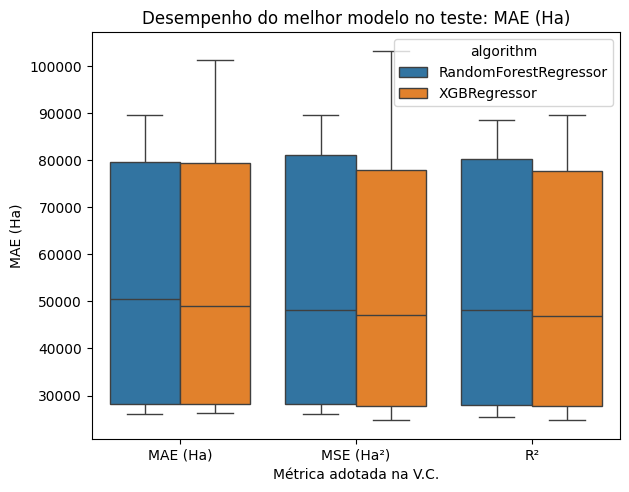

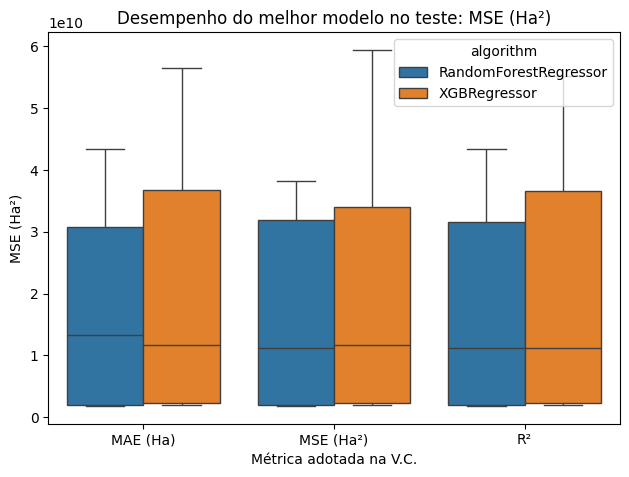

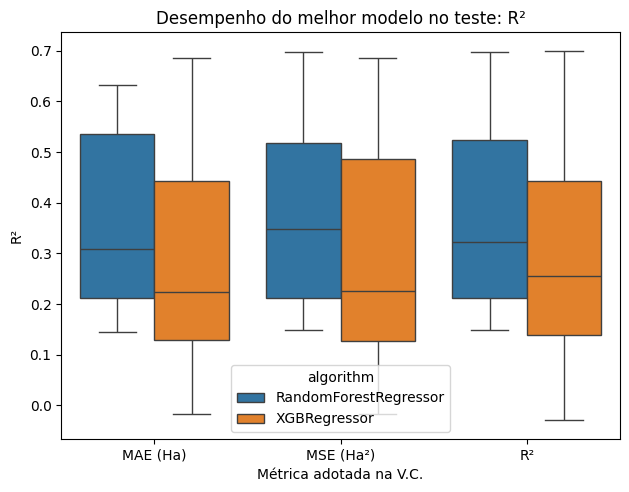

In [ ]:
class Performance():
    pass
perf = Performance()

# Formatação
perf.title = "Desempenho do melhor modelo no teste: {metric}"
perf.x_axis = "Métrica adotada na V.C."
perf.y_axis = "{metric}"

# Obtém versão normalizada por validação cruzada
perf.df_normalized = normalize_df_exp_plan_cv(exp.df_plan)

# Ajusta formatação das métricas
perf.df_formatted = perf.df_normalized.copy()
perf.df_formatted[key.cv_metric] = perf.df_formatted[key.cv_metric].map(fmt.map_metric)

# Exibe resultados das métricas por melhor cenário das validações cruzadas
for cv_metric, mapped in fmt.map_metric.items():
    metric_col = f"{rad.test}_{cv_metric}"

    # Exibe boxplot
    sns.boxplot(data=perf.df_formatted, x=key.cv_metric, y=metric_col, hue=key.model)
    plt.tight_layout()
    plt.title(perf.title.format(metric=mapped))
    plt.xlabel(perf.x_axis)
    plt.ylabel(perf.y_axis.format(metric=mapped))
    plt.show()

    print("\n") # Respiro visual

### Tabela comparativa

Para uma visão sintética do desempenho, construiu-se uma tabela comparativa com as médias e os desvios padrão das métricas avaliadas no conjunto de **teste**, obtidas dos melhores modelos da validação cruzada. Cada linha da tabela corresponde a um algoritmo avaliado segundo uma métrica específica de pós-processamento.

Do ponto de vista estatístico, se denotarmos por $ X $ a variável aleatória que representa o desempenho esperado de um determinado algoritmo, e assumirmos que os diferentes cenários do plano de experimentação constituem uma amostra aleatória simples (A.A.S.), então a **média amostral** $ \bar{X} $ atua como um estimador consistente de $\text{E}(X)$. Assim, pela **Lei dos Grandes Números**, ainda que o valor real de $\text{E}(X)$ seja inobservável, sua estimativa empírica obtida pela média fornece uma aproximação informativa do desempenho médio do modelo. Uma observação análoga pode ser feita a respeito do desvio padrão $\text{DP}(X)$.

In [ ]:
# Formatação
perf.table_title = "### Tabela comparativa de performance ###"

# Armazena resultados a comporem a tabela de desempenho
perf.data = {
    "modelo": [],
    "métrica": [],
    "média": [],
    "desvio padrão": []
}

# Constrói tabela comparativa de métricas
for cv_metric, formatted in fmt.map_metric.items():
    for model in exp.models:
        # Restringe ao modelo especificado
        df_model = perf.df_normalized[perf.df_normalized[key.model] == model]

        # Preenche campos da tabela
        perf.data["métrica"].append(formatted)
        perf.data["modelo"].append(model)
        perf.data["média"].append(df_model[f"{rad.test}_{cv_metric}"].mean()) # Computa média
        perf.data["desvio padrão"].append(df_model[f"{rad.test}_{cv_metric}"].std()) # Computa desvio padrão

perf.df_cmp_table = pd.DataFrame(data=perf.data)

# Exibe tabela
print(perf.table_title)
display(perf.df_cmp_table)

### Tabela comparativa de performance ###


,modelo,métrica,média,desvio padrão
0,RandomForestRegressor,MAE (Ha),5.397250e+04,2.639074e+04
1,XGBRegressor,MAE (Ha),5.346785e+04,2.616983e+04
2,RandomForestRegressor,MSE (Ha²),1.659436e+10,1.497225e+10
3,XGBRegressor,MSE (Ha²),1.875545e+10,1.742265e+10
4,RandomForestRegressor,R²,3.719583e-01,1.693104e-01
5,XGBRegressor,R²,2.996112e-01,1.937303e-01


## Análise de Coeficientes

### Análise da importância média das características por cenário

Para assegurar a interpretabilidade, consideraram-se apenas os casos sem PCA aplicado, isto é, com `PCA=0`. Assim, para cada cenário específico de seleção de características, extraem-se os coeficientes dos modelos envolvidos, e calcula-se a importância média de cada _feature_. Em seguida, geram-se gráficos de barras que mostram a importância média, segmentada por algoritmo, acompanhada do intervalo de confiança ao nível de significância definido. Essa visualização permite comparar a relevância das variáveis entre os diferentes modelos e cenários, facilitando a interpretação dos resultados.

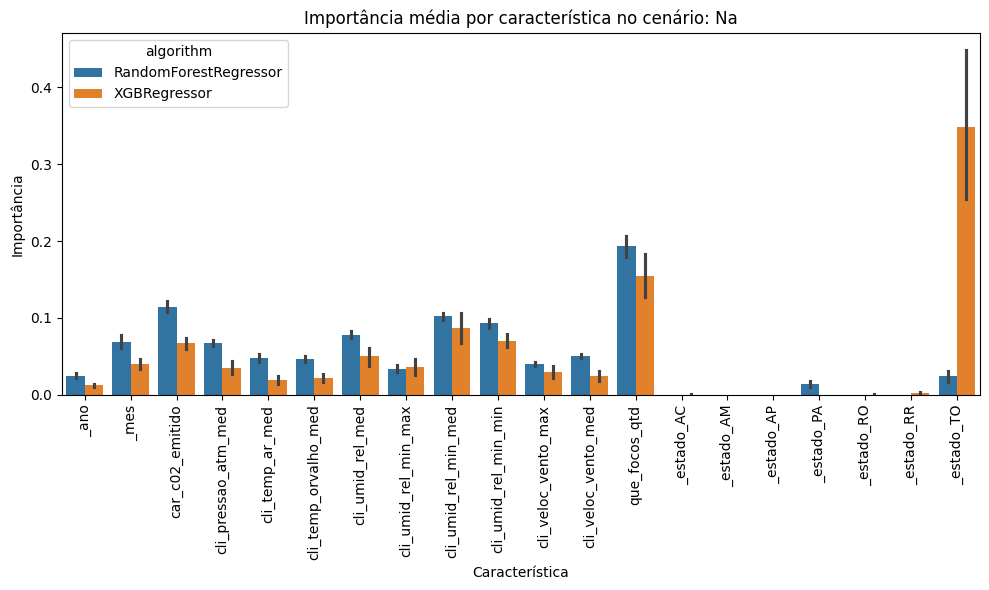

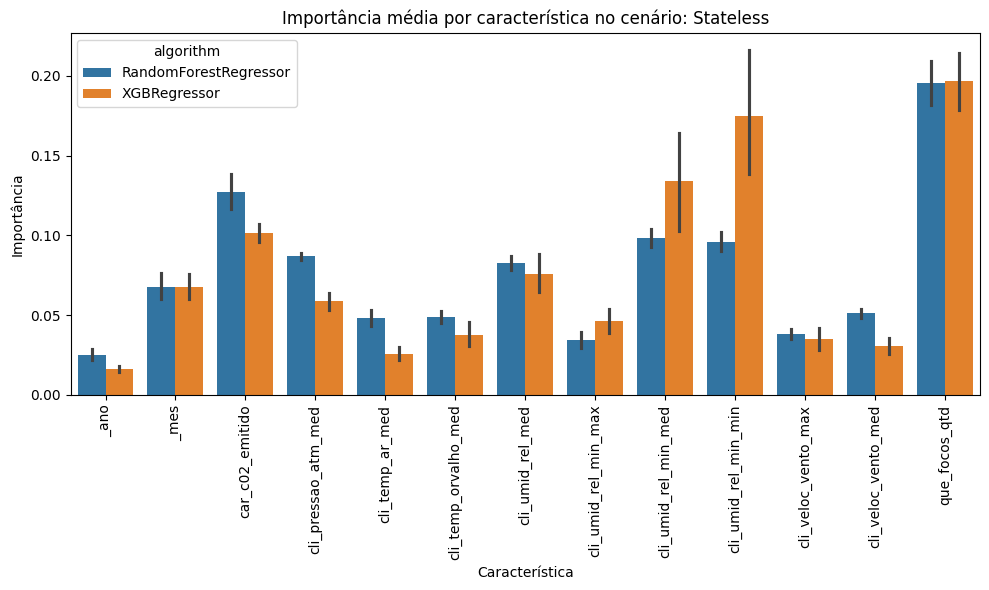

In [ ]:
class Coeficient:
    pass
coef = Coeficient()

# Constantes auxiliares
coef.alpha = 5 # Nível de significância (%)

# Formatação
coef.title = "Importância média por característica no cenário: {scenario}"
coef.x_axis = "Característica"
coef.y_axis = "Importância"

# Obtém cenários sem PCA aplicado
coef.df_pcaless = exp.df_plan[exp.df_plan[key.pca] == 0]

for scenario in exp.fs_scenarios:
    # Filtra o cenário de seleção de features desejado
    coef.df_scenario = coef.df_pcaless[
        coef.df_pcaless[key.cs].apply(
            lambda x: mask.fs.format(scenario) in x
        )
    ]

    # Obtém DataFrame dos coeficientes por cada modelo
    coef.df_coefs = get_coefs(coef.df_scenario)

    """
    Plota gráfico de barras da média por coeficiente com intervalo de confiança
    ao nível de significância alfa.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        estimator="mean",                   # Agrega pela média
        data=coef.df_coefs,
        x=key.feat,
        y=key.imp,
        hue=key.model,
        errorbar=("ci", 100 - coef.alpha)   # Exibe intervalo de confiança
    )
    plt.title(coef.title.format(scenario=scenario.capitalize()))
    plt.xlabel(coef.x_axis)
    plt.ylabel(coef.y_axis)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

## Análise de Cenários de Pré-Processamento

### Avaliação do impacto das etapas de pré-processamento no desempenho dos modelos

Esta seção busca avaliar o impacto das diferentes etapas de pré-processamento no desempenho dos modelos de regressão. Para isso, consideram-se apenas os experimentos cuja validação cruzada adotou o R² como métrica de referência, de modo a garantir a comparabilidade entre os resultados.

As etapas analisadas incluem a seleção de características, a remoção de _outliers_ e a normalização dos dados. Para cada uma dessas variações, os dados são reorganizados em formato longo, o que permite a visualização do desempenho dos modelos por meio de _boxplots_ segmentados por métrica de pós-processamento. Além disso, analisa-se o efeito da aplicação da Análise de Componentes Principais (PCA) sobre o desempenho, utilizando gráficos de pontos (_pointplots_), que comparam os valores médios obtidos para cada número de componentes principais considerados. Quando `PCA = 0`, têm-se os casos sem PCA aplicado. Essa abordagem permite observar de forma clara como diferentes decisões de pré-processamento influenciam a qualidade preditiva dos modelos avaliados.

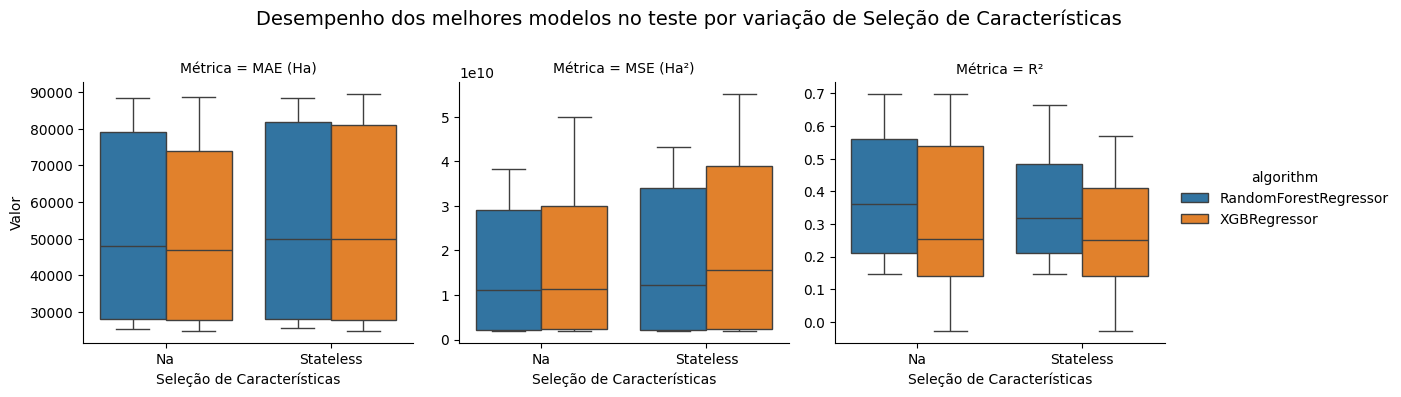

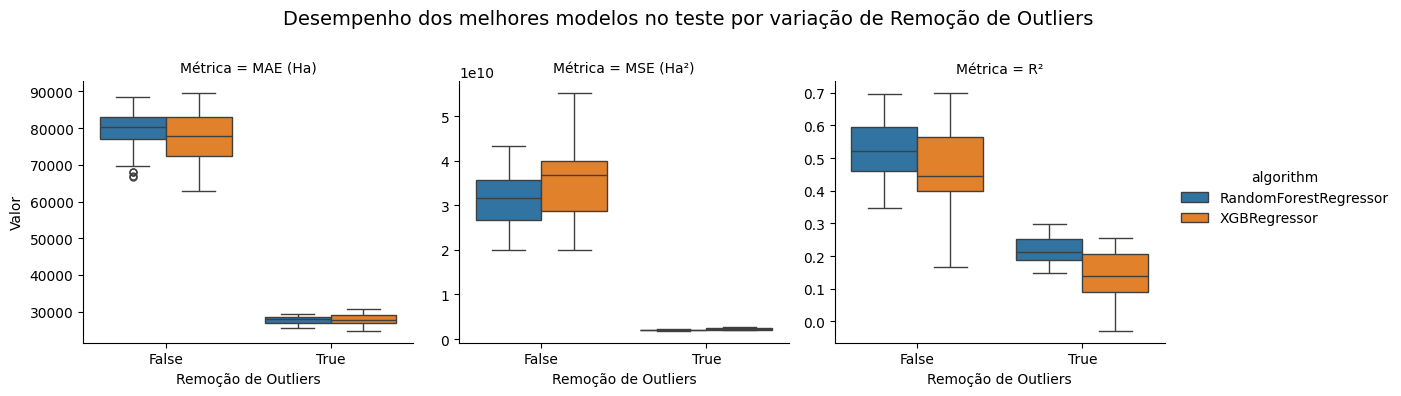

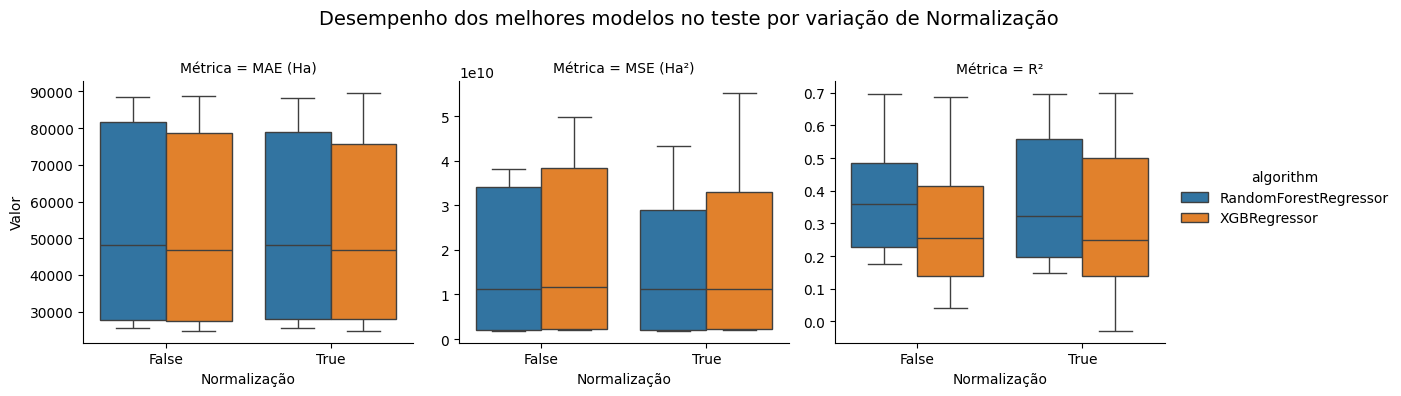

In [ ]:
class PreProcessing:
    pass
pre = PreProcessing()

# Constantes auxiliares
pre.ref = "r2" # Métrica de referência usada na Validação Cruzada

pre.steps = {
    key.fs: "Seleção de Características",
    key.out: "Remoção de Outliers",
    key.norm: "Normalização"
}

pre.metrics = {
    f"{rad.test}_mae": "MAE (Ha)",
    f"{rad.test}_mse": "MSE (Ha²)",
    f"{rad.test}_r2": "R²",
}

# Formatação
pre.plot = "box"
pre.metric = "Métrica"
pre.title = "Desempenho dos melhores modelos no teste por variação de {step_name}"
pre.y_axis = "Valor"

# Restringe apenas aos casos que tenham usado a métrica de referência em sua Validação Cruzada
pre.df = normalize_df_exp_plan_cv(exp.df_plan)
pre.df = pre.df[pre.df[key.cv_metric] == pre.ref]
pre.df = pre.df.rename(columns=pre.metrics)

# Renomeia cenários
for scenario in exp.fs_scenarios:
    pre.df.loc[
        pre.df[key.cs].apply(lambda key: mask.fs.format(scenario) in key),
        key.fs
    ] = scenario.capitalize()

# Para cada etapa de pré-processamento:
for step, step_name in pre.steps.items():
    # Transforma DataFrame para formato longo
    pre.df_melted = pre.df.melt(
        id_vars=[key.model, step],  # Colunas que permanecem
        value_vars=[metric for metric in pre.metrics.values()],  # Métricas
        var_name= pre.metric,
        value_name=pre.y_axis
    )

    # Plota subgráficos: um por variação do pré-processamento
    pre.g = sns.catplot(
        data=pre.df_melted,
        kind=pre.plot,
        x=step,
        y=pre.y_axis,
        hue=key.model,
        col=pre.metric,
        col_wrap=3,     # Controla quantos gráficos por linha
        height=4,
        aspect=1,
        sharey=False    # Gráficos não compartilham escala
    )
    pre.g.figure.subplots_adjust(top=0.8)
    pre.g.figure.suptitle(pre.title.format(step_name=step_name), fontsize=14)
    pre.g.set_axis_labels(step_name, pre.y_axis)
    plt.show()

    print("\n")

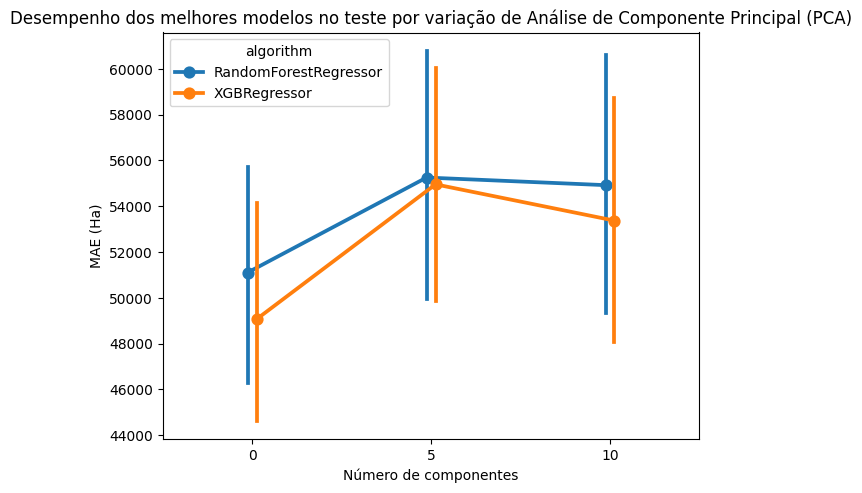

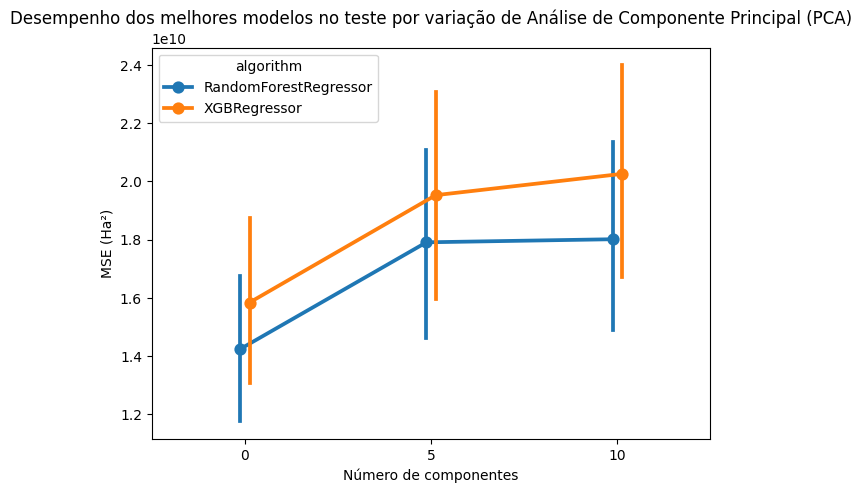

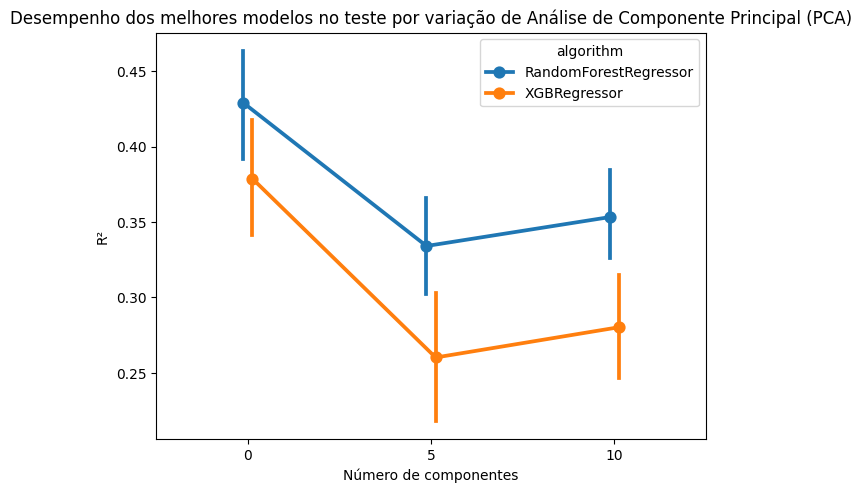

In [ ]:
pre.pca = "Análise de Componente Principal (PCA)"
pre.pca_x_axis = "Número de componentes"

# Exibe pointplot por métrica
for cv_metric in pre.metrics.values():
    sns.pointplot(data=pre.df,
                  x=key.pca,
                  y=cv_metric,
                  hue=key.model,
                  dodge=True        # Evita sobreposição
                  )
    plt.tight_layout()
    plt.title(pre.title.format(step_name=pre.pca))
    plt.xlabel(pre.pca_x_axis)
    plt.show()

    print("\n")

## Validação Cruzada

### Avaliação da estabilidade dos modelos via Validação Cruzada

Esta etapa visa investigar a estabilidade dos modelos em diferentes execuções da Validação Cruzada, a partir da distribuição dos valores obtidos para a métrica de referência em cada _fold_. Assim, para cada combinação de modelo e número de _folds_, são selecionados os experimentos correspondentes, extraídos os valores associados a cada _fold_ e gerados gráficos do tipo _boxplot_ com a respectiva distribuição. Essa visualização permite verificar a consistência do desempenho preditivo entre partições, contribuindo para a avaliação da robustez de cada modelo.

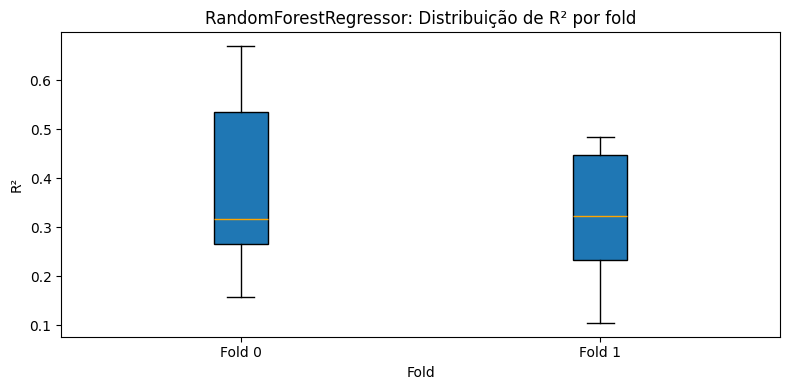

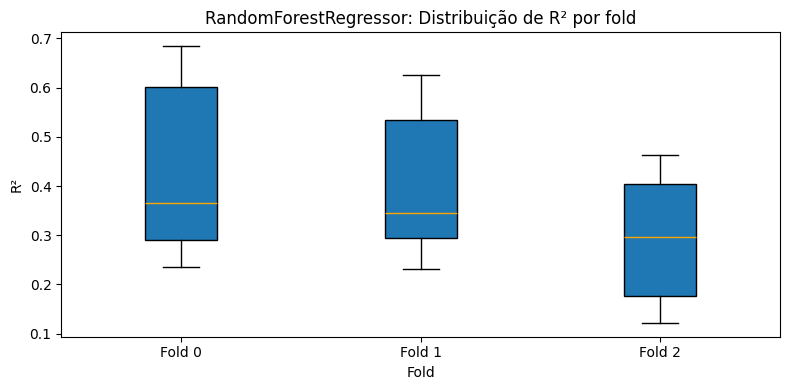

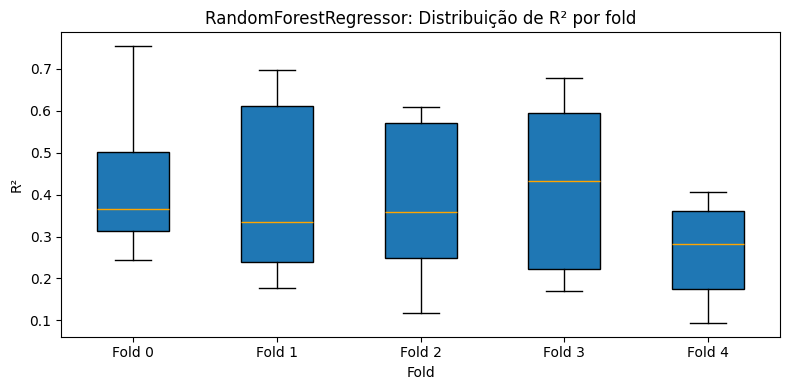

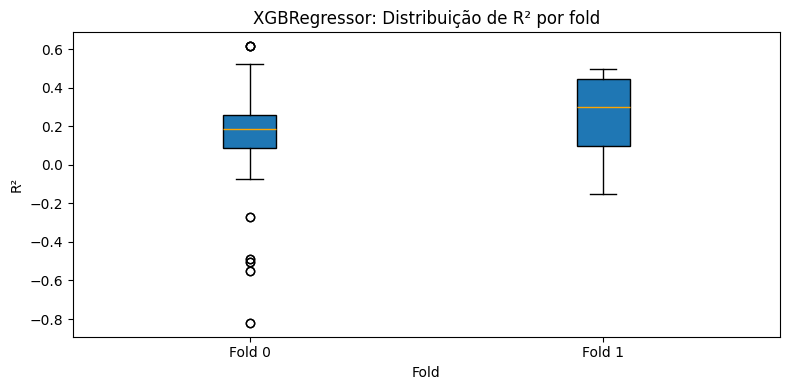

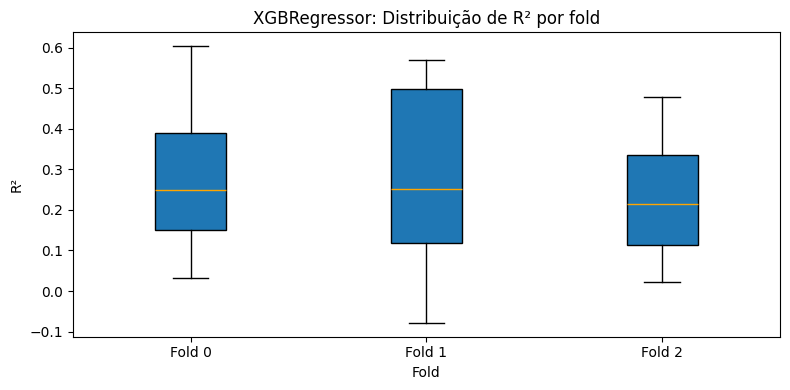

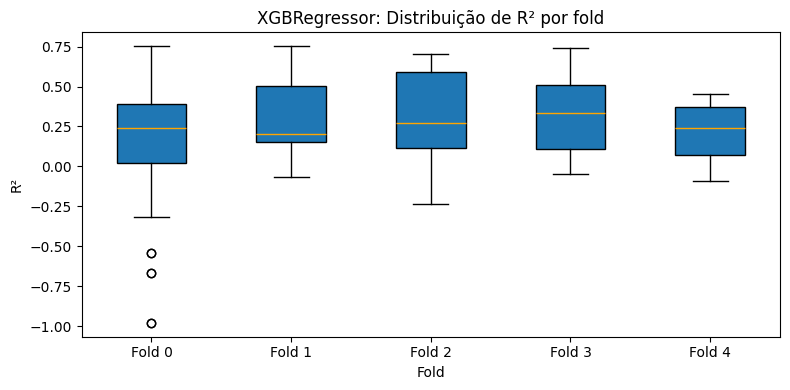

In [ ]:
class CrossValidation:
    pass
cv = CrossValidation()
cv.df = normalize_df_exp_plan_cv(exp.df_plan)
cv.ref_metric = "r2" # Métrica de referência

# Formatação
cv.title = "{model}: Distribuição de {metric_name} por fold"
cv.x_label = "Fold"
cv.ref_metric_name = fmt.map_metric[cv.ref_metric] # Nome a ser exibido para a métrica

# Para cada modelo:
for model in exp.models:
    cv.df_model = cv.df[cv.df[key.model] == model]

    # Para cada cenário de Validação Cruzada:
    for fold_num in exp.cv_folds:
        # Seleciona apenas cenários com o número de folds em questão
        mask_cv = mask.cv.format(fold_num)
        mask_df = cv.df_model[key.cs].str.contains(mask_cv, na=False)
        cv.df_fold = cv.df_model[mask_df]
        cv.df_fold = cv.df_fold.dropna(axis=1, how="all")

        # Limita à métrica de referência
        subset = cv.df_fold[cv.df_fold[key.cv_metric] == cv.ref_metric]

        # Identifica colunas de fold
        fold_cols = [c for c in subset.columns if c.startswith(f"{rad.fold}_")]

        # Extrai números dos folds para os labels
        folds = [int(c.split('_')[-1]) for c in fold_cols]

        # Prepara os dados: lista de arrays, um para cada fold
        data = [subset[c].dropna() for c in fold_cols]

        # Plota boxplot
        plt.figure(figsize=(8, 4))
        plt.boxplot(
            data,
            tick_labels=[f"Fold {f}" for f in folds],
            patch_artist=True,
            medianprops=dict(color="orange"),
            )
        plt.title(cv.title.format(
                model=model,
                metric_name=cv.ref_metric_name
            )
        )
        plt.xlabel(cv.x_label)
        plt.ylabel(cv.ref_metric_name)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

### Análise cruzada entre número de _folds_ e métrica de validação cruzada

Esta seção tem como propósito investigar como o desempenho dos modelos é influenciado por diferentes combinações entre a métrica adotada na validação cruzada e o número de _folds_ utilizados. Para cada modelo, calcula-se a média da métrica de referência (R² no teste) em função dessas variações, considerando os diferentes cenários experimentais. Os resultados são organizados em uma matriz e visualizados por meio de um _heatmap_, no qual as linhas representam as métricas utilizadas na validação cruzada, e as colunas correspondem ao número de _folds_. Os valores contidos nas células indicam o desempenho médio obtido no conjunto de teste para a métrica de referência, possibilitando identificar padrões e interações relevantes entre esses dois fatores de configuração.

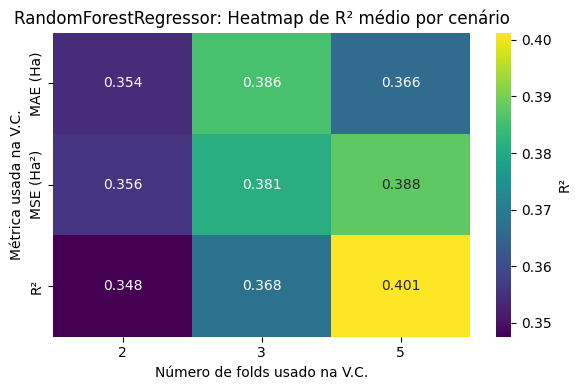

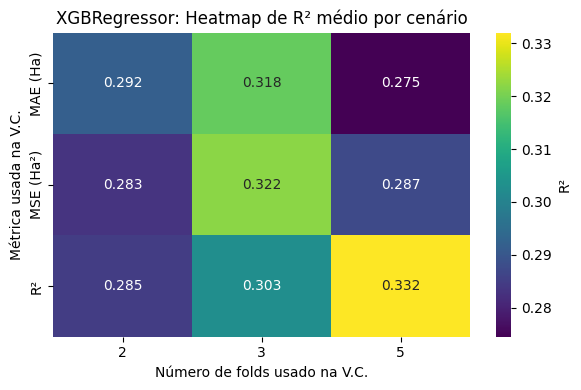

In [ ]:
# Formatação
cv.heat_title = "{model}: Heatmap de {metric_name} médio por cenário"
cv.heat_x_label = "Número de folds usado na V.C."
cv.heat_y_label = "Métrica usada na V.C."
cv.heat_label = f"{cv.ref_metric_name} no conjunto de teste"

heatmap_data = pd.DataFrame(
    index=fmt.map_metric.values(),
    columns=exp.cv_folds,
    dtype=float
)

# Para cada algoritmo:
for model in exp.models:
    cv.df_model = cv.df[cv.df[key.model] == model]

    # Itera sobre cada métrica registrada
    for cv_metric, metric_name in fmt.map_metric.items():
        cv.df_metric = cv.df_model[cv.df_model[key.cv_metric] == cv_metric]

        # Itera por cada número de fold usado na V.C.
        for fold_num in exp.cv_folds:
            mask_cv = mask.cv.format(fold_num)
            mask_df = cv.df_metric[key.cs].str.contains(mask_cv, na=False)
            cv.df_fold = cv.df_metric[mask_df]

            # Calcula média da métrica de referência com base nos cenários
            ref_metric_mean = cv.df_fold[f"{rad.test}_{cv.ref_metric}"].astype(float).mean()
            heatmap_data.loc[metric_name, fold_num] = ref_metric_mean

    # Plota o heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        cbar_kws={"label": cv.ref_metric_name}
    )
    plt.title(cv.heat_title.format(model=model, metric_name=cv.ref_metric_name))
    plt.xlabel(cv.heat_x_label)
    plt.ylabel(cv.heat_y_label)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

## Análise de Cenários

### Análise da influência dos hiperparâmetros no desempenho dos modelos

Esta etapa tem como objetivo examinar o impacto de diferentes valores de hiperparâmetros no desempenho dos modelos, utilizando como base os resultados obtidos no conjunto de teste. A visualização é feita por meio de _violinplots_, que ilustram a distribuição dos resultados de desempenho por modelo, segmentados de acordo com o valor do hiperparâmetro em análise. Esse tipo de gráfico permite observar não apenas as diferenças entre médias ou medianas, mas também a variação interna das distribuições, contribuindo para uma análise mais completa do efeito dos hiperparâmetros sobre a _performance_ dos algoritmos.

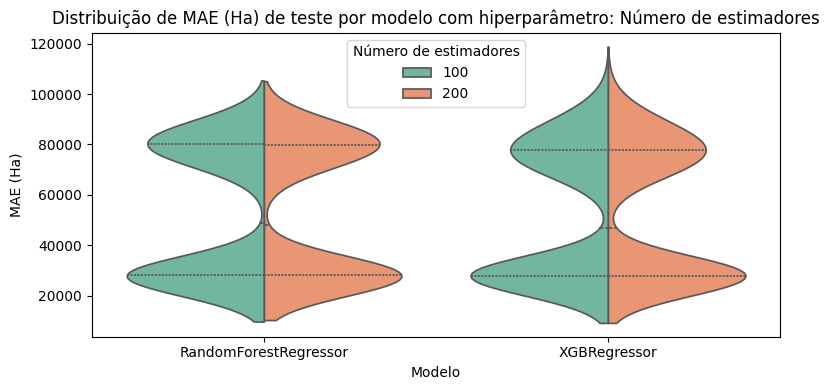

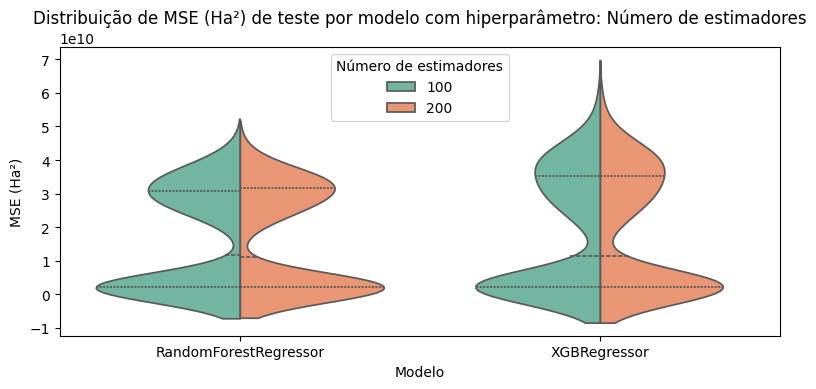

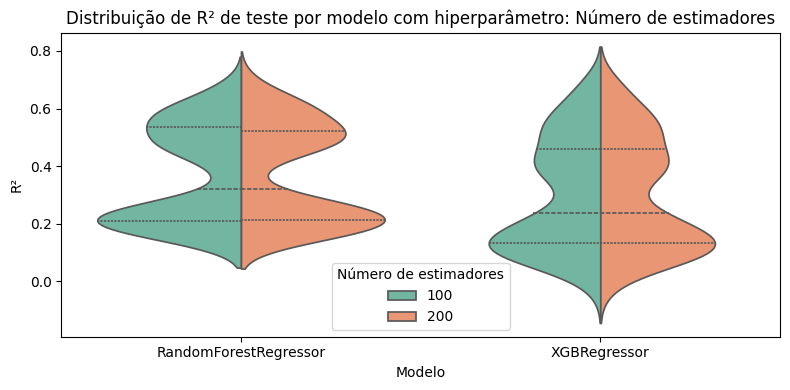

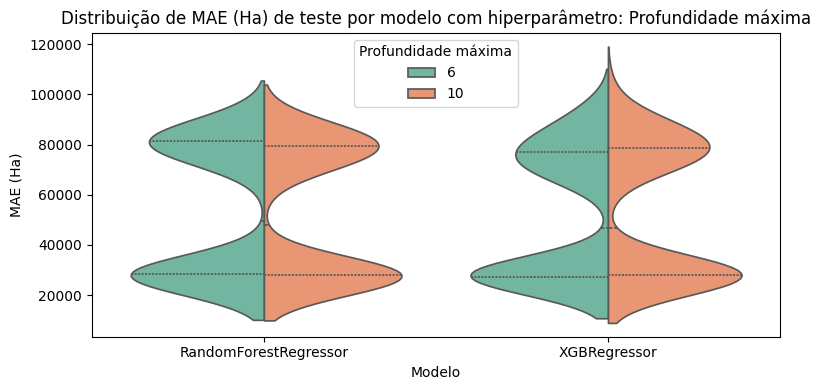

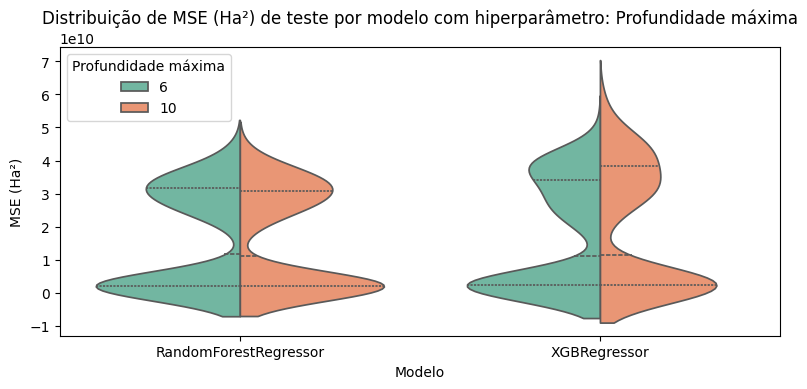

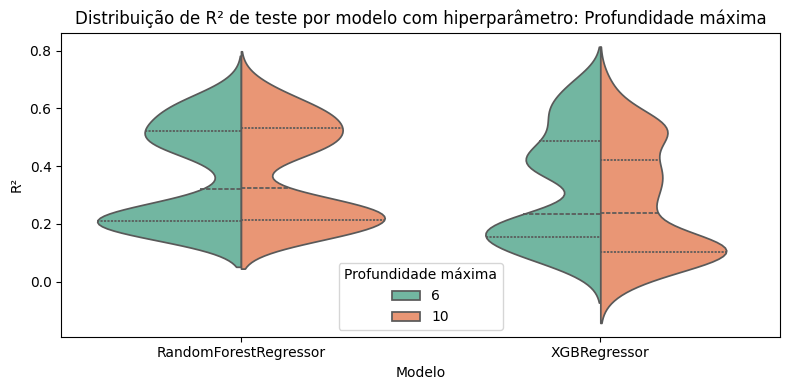

In [ ]:
class ScenarioAnalysis:
    pass
sa = ScenarioAnalysis()
sa.df = normalize_df_exp_plan_cv(exp.df_plan)

# Formatação
sa.title = "Distribuição de {metric_name} de teste por modelo com hiperparâmetro: {param}"
sa.x_label = "Modelo"
sa.y_label = "{metric_name}"

# Para cada hiperparâmetro:
for param, param_name in fmt.map_param.items():
    # Para cada métrica no conjunto de teste:
    for cv_metric, metric_name in fmt.map_metric.items():
        # Exibe violinplot
        plt.figure(figsize=(8, 4))
        sns.violinplot(
            data=sa.df,
            x=key.model,                # Categorias
            y=f"{rad.test}_{cv_metric}",   # Valores contínuos
            hue=param,
            split=True,                 # Se tiver só duas categorias em "hue", divide o violino ao meio
            inner="quartile",           # Desenha quartis dentro do violino
            palette="Set2"              # Paleta de cores
        )
        plt.title(sa.title.format(metric_name=metric_name, param=param_name))
        plt.xlabel(sa.x_label)
        plt.ylabel(sa.y_label.format(metric_name=metric_name))
        plt.legend(title=param_name)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

### Análise do efeito da profundidade máxima e da remoção de _outliers_ no desempenho dos modelos

Esta etapa avalia como a variação da profundidade máxima dos modelos e a aplicação da remoção de _outliers_ influenciam o desempenho preditivo. Essa investigação foi motivada pelo efeito antagônico entre o aumento da profundidade, que tende a proporcionar maior precisão às custas da robustez, e a remoção de _outliers_ — que reforça a robustez, porém pode comprometer a precisão. Para cada modelo e métrica de avaliação, são gerados _boxplots_ que exibem a distribuição dos valores no conjunto de teste. Os gráficos apresentam a profundidade máxima no eixo horizontal e a métrica de desempenho no eixo vertical, com cores diferenciando os casos com e sem remoção de _outliers_. Dessa forma, espera-se identificar, para cada algoritmo, a configuração ótima que maximize o equilíbrio entre robustez e precisão.

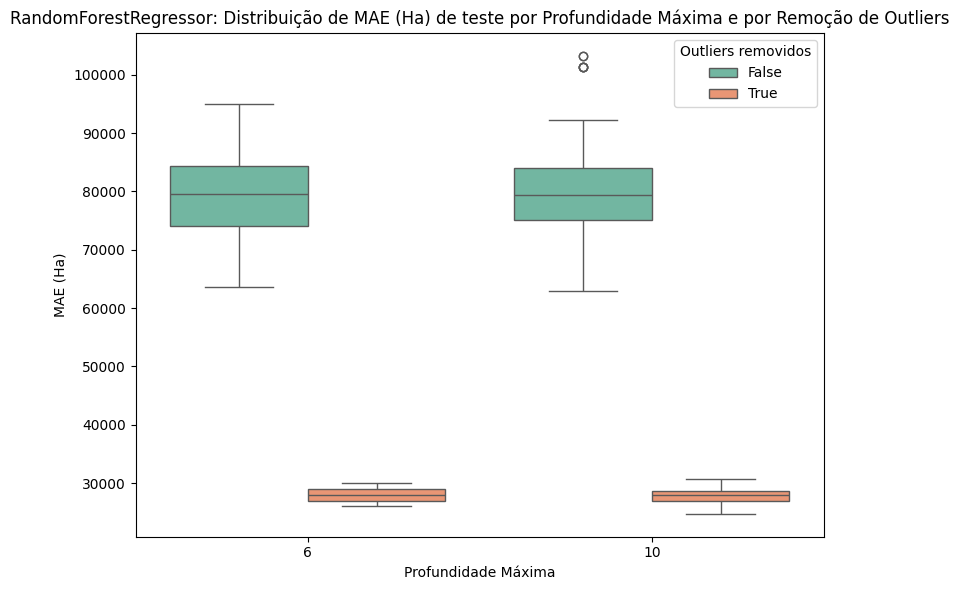

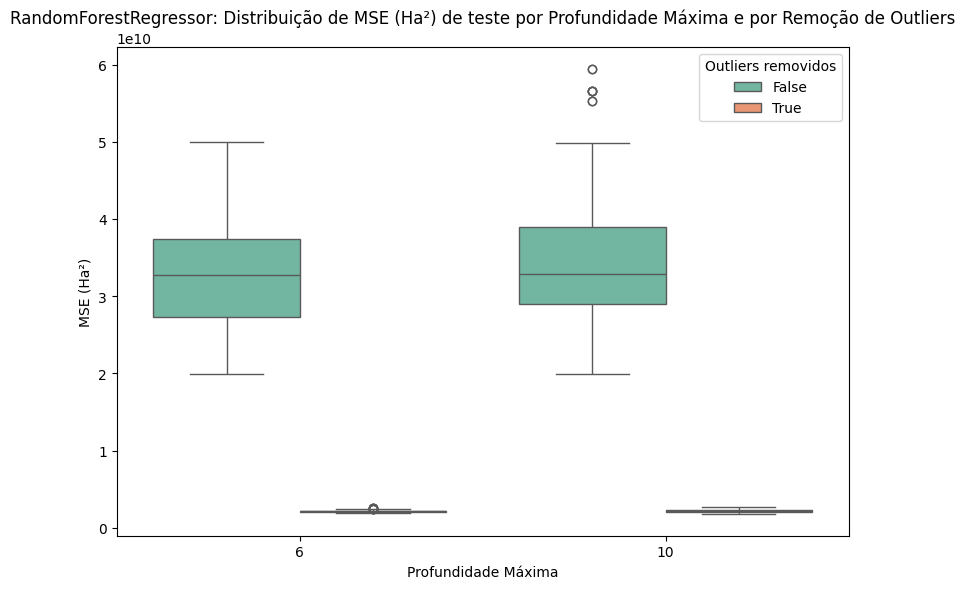

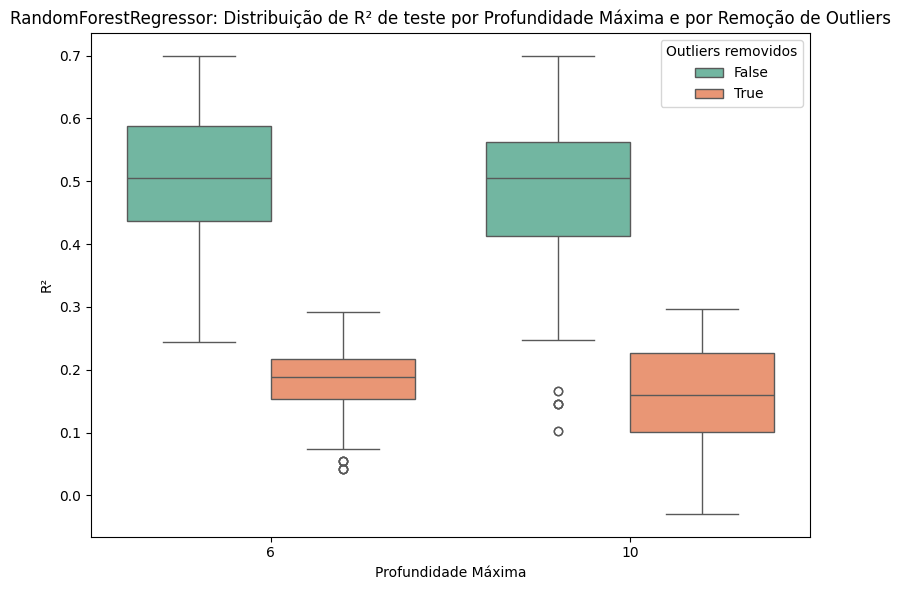

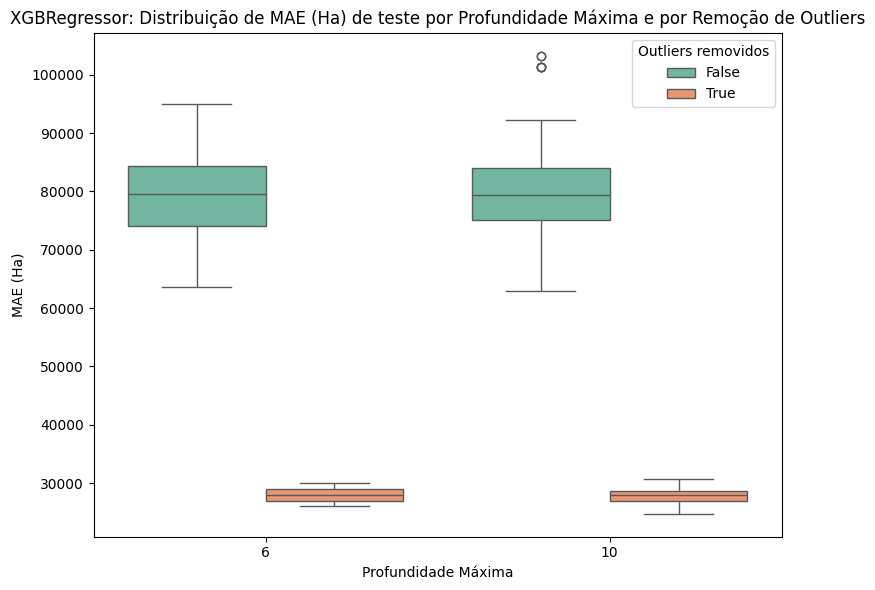

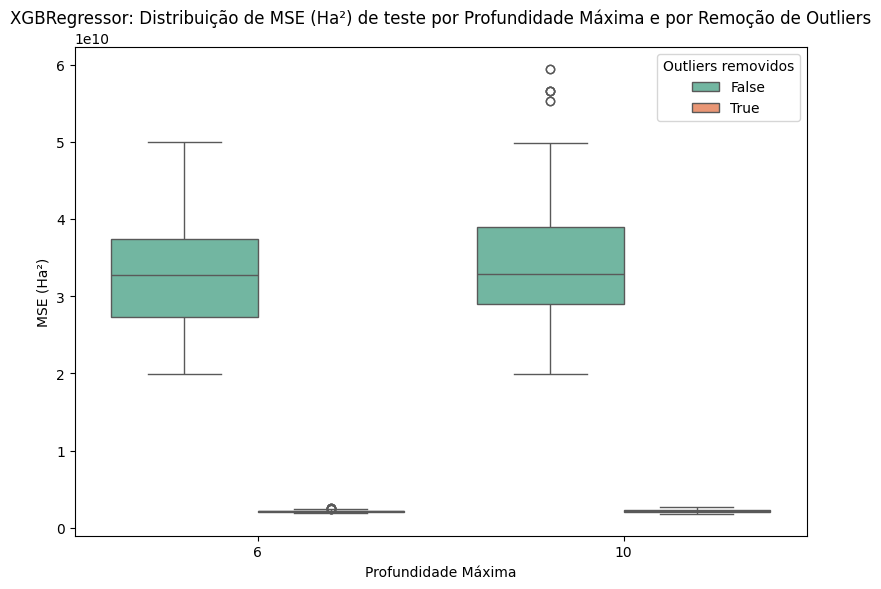

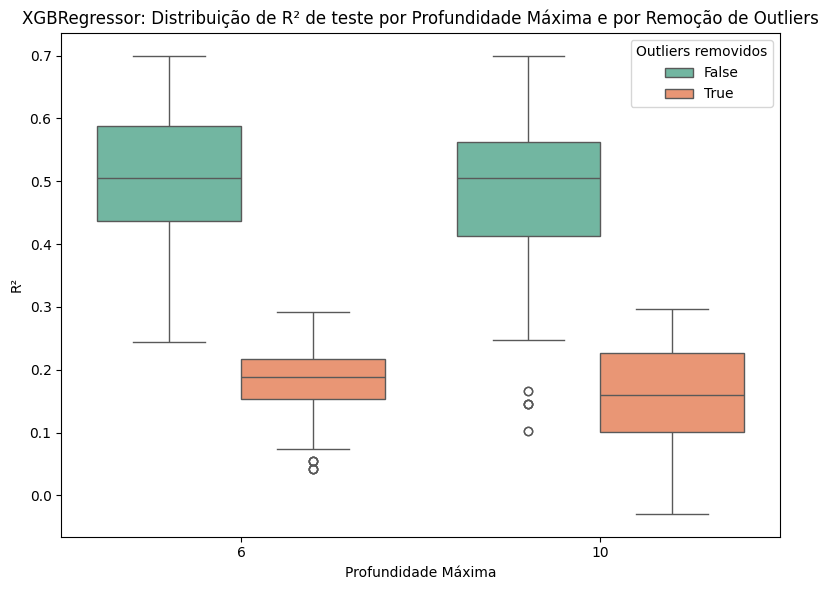

In [ ]:
# Formatação
sa.out_title = "{model}: Distribuição de {metric_name} de teste por Profundidade Máxima e por Remoção de Outliers"
sa.x_label = "Profundidade Máxima"
sa.y_label = "{metric_name}"
sa.leg_title = "Outliers removidos"

for model in exp.models:
    for cv_metric, metric_name in fmt.map_metric.items():
        # Exibe boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(
            data=sa.df,
            x=key.max_depth,
            y=f"{rad.test}_{cv_metric}",
            hue=key.out,
            palette="Set2"
        )
        plt.title(sa.out_title.format(model=model, metric_name=metric_name))
        plt.xlabel(sa.x_label)
        plt.ylabel(sa.y_label.format(metric_name=metric_name))
        plt.legend(title=sa.leg_title)
        plt.tight_layout()
        plt.show()

        print("\n") # Respiro visual

## Intervalos de Confiança

### Cálculo de intervalos de confiança para as métricas de desempenho dos modelos

Nesta etapa, são calculados os intervalos de confiança para as principais métricas de desempenho dos modelos, considerando tanto os conjuntos de treino quanto de teste. O nível de significância pré-determinado é de $5 \%$ ($\alpha = 0.05$), resultando em um intervalo de confiança de $95 \%$.

Para cada modelo, métrica e conjunto de dados, são extraídas as amostras correspondentes. A métrica de treino foi calculada considerando todos os _folds_ de treino, inclusive aqueles que não envolviam o melhor modelo, de modo a garantir que a média fosse mais representativa. Em seguida, o intervalo de confiança é estimado utilizando a distribuição T de Student. Os resultados são organizados em uma tabela comparativa que inclui o tamanho da amostra, os limites inferior e superior do intervalo, e o ponto médio estimado. Posteriormente, os intervalos são graficamente exibidos. Essa análise fornece uma medida estatística da precisão das estimativas das métricas, auxiliando na avaliação da robustez dos resultados apresentados.

In [ ]:
class ConfidenceInterval:
    pass
ci = ConfidenceInterval()

# Confiança
ci.alpha = 0.05
ci.conf = 1.0 - ci.alpha

# Formatação
ci.title = f"### Nível de significância pré-determinado: {ci.alpha} ###"
ci.key_model = "Modelo"
ci.key_avg = "Ponto médio"
ci.key_n = "Tamanho da amostra"
ci.key_metric = "Métrica"
ci.key_inf = "Limite inferior"
ci.key_sup = "Limite superior"
ci.key_dataset = "Conjunto"
ci.map_dataset = {
    fmt.train: get_train_metric_series,
    fmt.test: get_test_metric_series,
}

# Armazena informações da tabela
ci.data = {
    ci.key_model: [],
    ci.key_dataset: [],
    ci.key_metric: [],
    ci.key_n: [],
    ci.key_inf: [],
    ci.key_avg: [],
    ci.key_sup: [],
}
ci.df = exp.df_plan.copy()

# Computa intervalos de confiança
for model in exp.models: # Por modelo
    ci.df_model = ci.df[ci.df[key.model] == model]

    for cv_metric, metric_name in fmt.map_metric.items(): # Por métrica
        for dataset, function in ci.map_dataset.items(): # Por dataset (treino, teste)
            ci.data[ci.key_model].append(model)
            ci.data[ci.key_dataset].append(dataset)
            ci.data[ci.key_metric].append(metric_name)

            series = function(ci.df_model, cv_metric) # Obtém amostra de valores
            n, inf, avg, sup = ci_mean_t_student(series, ci.conf) # Calcula I.C. a partir da amostra (usa a T de Student)

            ci.data[ci.key_n].append(n)
            ci.data[ci.key_inf].append(inf)
            ci.data[ci.key_avg].append(avg)
            ci.data[ci.key_sup].append(sup)

# Constrói tabela comparativa
ci.cmp_table = pd.DataFrame(data=ci.data)
ci.cmp_table[ci.key_n] = ci.cmp_table[ci.key_n].astype("Int32")

print(ci.title)
display(ci.cmp_table)

### Nível de significância pré-determinado: 0.05 ###


,Modelo,Conjunto,Métrica,Tamanho da amostra,Limite inferior,Ponto médio,Limite superior
0,RandomForestRegressor,Treino,MAE (Ha),960,4.785526e+04,4.956075e+04,5.126624e+04
1,RandomForestRegressor,Teste,MAE (Ha),864,5.221031e+04,5.397250e+04,5.573469e+04
2,RandomForestRegressor,Treino,MSE (Ha²),960,1.542725e+10,1.669248e+10,1.795770e+10
3,RandomForestRegressor,Teste,MSE (Ha²),864,1.559462e+10,1.659436e+10,1.759411e+10
4,RandomForestRegressor,Treino,R²,960,3.689343e-01,3.791182e-01,3.893022e-01
5,RandomForestRegressor,Teste,R²,864,3.606529e-01,3.719583e-01,3.832636e-01
6,XGBRegressor,Treino,MAE (Ha),960,4.938909e+04,5.116424e+04,5.293939e+04
7,XGBRegressor,Teste,MAE (Ha),864,5.172041e+04,5.346785e+04,5.521528e+04
8,XGBRegressor,Treino,MSE (Ha²),960,1.816997e+10,1.957600e+10,2.098203e+10
9,XGBRegressor,Teste,MSE (Ha²),864,1.759209e+10,1.875545e+10,1.991881e+10


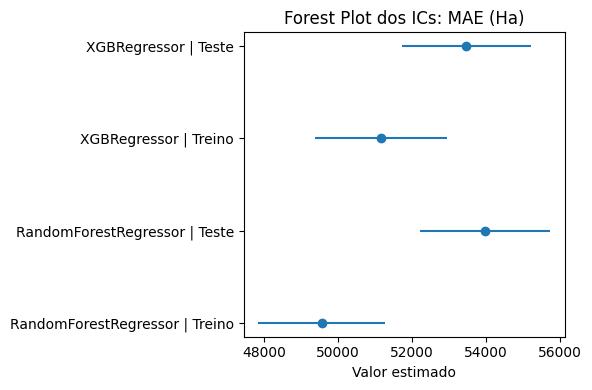

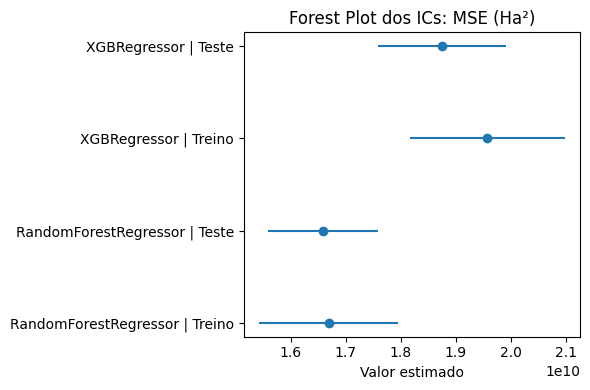

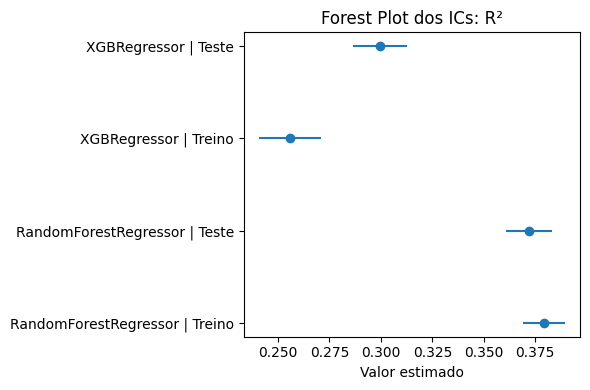

In [ ]:
# Formatação
ci.forest_title = "Forest Plot dos ICs: {}"
ci.x_label = "Valor estimado"

# Exibe visualização do intervalo de confiança para cada métrica
for cv_metric in fmt.map_metric.values():
    df_aux = ci.cmp_table[ci.cmp_table[ci.key_metric] == cv_metric]

    labels = df_aux[ci.key_model] + " | " + df_aux[ci.key_dataset]
    y = np.arange(len(labels))
    sample_series = df_aux[ci.key_avg]
    xerr = np.vstack([
        sample_series - df_aux[ci.key_inf],
        df_aux[ci.key_sup] - sample_series
    ])

    # Exibe forest plot
    plt.figure(figsize=(6, 4))
    plt.errorbar(sample_series, y, xerr=xerr, fmt='o')
    plt.title(ci.forest_title.format(cv_metric))
    plt.xlabel(ci.x_label)
    plt.yticks(y, labels)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

## Teste de Hipótese

Conforme preconizado por Fisher, seja fixado o nível de significância $\alpha = 0.05$ antes da realização dos testes de hipótese, a fim de que não haja enviesamento. A escolha do valor de $5\%$ apoia-se em sua ampla adoção pela comunidade científica, sendo uma convenção iniciada pelo próprio Fisher (1974).

### Referência
Fisher, R.A. **The design of experiments**. Nona edição. Nova Iorque: Hafner Press; 1974.

In [ ]:
class HypothesisTest:
    pass
ht = HypothesisTest()
ht.alpha = 0.05

# Critérios baseiam-se no parâmetro "alternative" das funções de cálculo de p-valor
ht.map_test_criteria = {
    "mae": "less",  # Melhor se minimizada
    "mse": "less",  # Melhor se minimizada
    "r2": "greater" # Melhor se maximizada
}

# Formatação
ht.pval_title = "\tP-Valor: {pval}"
ht.reject = "\tComo o p-valor foi menor ou igual a alfa, devemos rejeitar H0."
ht.no_reject = "\tComo o p-valor foi maior que alfa, não há evidências para rejeitar H0."

ht.df = exp.df_plan.copy()

### Comparação do desempenho entre treino e teste

Deseja-se saber, para um dado algoritmo, se o desempenho de teste foi superior ou equivalente ao de treino, de maneira a sugerir boa generalização. Para tanto, definam-se as seguintes hipóteses:

Sejam $\mu_{treino}$ o valor esperado da métrica média no conjunto de treino e $\mu_{teste}$ no de teste. Há duas possibilidades:
<br><br>

**Otimizar a métrica equivale a maximizá-la**
$$
\left\{
\begin{aligned}
H_0 &: \mu_{teste} < \mu_{treino}\\
H_1 &: \mu_{teste} \geq \mu_{treino}
\end{aligned}
\right.
$$

<br><br>
**Otimizar a métrica equivale a minimizá-la**
$$
\left\{
\begin{aligned}
H_0 &: \mu_{teste} > \mu_{treino}\\
H_1 &: \mu_{teste} \leq \mu_{treino}
\end{aligned}
\right.
$$
<br>

Realize-se o teste de hipótese para todas as combinações possíveis de modelo e de métrica, a fim de determinar, com segurança, a capacidade de generalização para o conjunto de teste.

In [ ]:
# Formatação
ht.train_test_h0 = "### H0: {model} desempenhou melhor no treino que no teste segundo {metric_name} ###"

for model in exp.models: # Por modelo
    ht.df_model = ht.df[ht.df[key.model] == model]

    for cv_metric, metric_name in fmt.map_metric.items(): # Por métrica
        # Obtém série das métricas dos melhores modelos no teste
        ht.test_sample = get_test_metric_series(ht.df_model, cv_metric)
        ht.train_sample = get_train_metric_series(ht.df_model, cv_metric)

        """
        Cálculo do p-valor a partir do teste da T de Student para diferença entre
        médias de amostras com variâncias supostas diferentes, que usa a
        aproximação do número de graus de liberdade de Welch.
        """
        t_test, pval = stats.ttest_ind(
            a=ht.test_sample,
            b=ht.train_sample,
            equal_var=False,
            alternative=ht.map_test_criteria[cv_metric] # Define se a métrica deve ser maximizada ("greater") ou minimizada ("less")
        )

        print(ht.train_test_h0.format(model=model, metric_name=metric_name))
        print(ht.pval_title.format(pval=pval))

        # Rejeição ou não rejeição da hipótese nula
        if pval >= ht.alpha:
            print(ht.no_reject)
        else:
            print(ht.reject)

        print("\n") # Respiro visual

### H0: RandomForestRegressor desempenhou melhor no treino que no teste segundo MAE (Ha) ###
	P-Valor: 0.9997875572910506
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: RandomForestRegressor desempenhou melhor no treino que no teste segundo MSE (Ha²) ###
	P-Valor: 0.4524812925544586
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: RandomForestRegressor desempenhou melhor no treino que no teste segundo R² ###
	P-Valor: 0.8220670367100368
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: XGBRegressor desempenhou melhor no treino que no teste segundo MAE (Ha) ###
	P-Valor: 0.9651552064923727
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: XGBRegressor desempenhou melhor no treino que no teste segundo MSE (Ha²) ###
	P-Valor: 0.18883089373322742
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: XGBRegressor desempenhou melhor n

### Comparação entre modelos

Como o _XGBoost_ é um algoritmo mais recente e, supostamente, superior ao _Random Forest_ (TIANQI _et al._, 2016), espera-se que, em geral, seu desempenho seja melhor. Por outro lado, à exceção do MAE, o _Random Forest_ parece ter desempenhado melhor. Verifiquem-se essas hipóteses ao nível de significância pré-definido.

\
Sejam $\mu_{XGB}$ o valor esperado e $\sigma_{XGB}$ a variância da métrica média no conjunto de teste para o modelo `XGBoostRegressor` e $\mu_{RF}$ o valor esperado e $\sigma_{RF}$ a variância no teste para o `RandomForestRegressor`. Defina supondo _XGBoost_ melhor e uma métrica a ser minimizada:
<br><br>

**Comparação de precisão**
$$
\left\{
\begin{aligned}
H_0 &: \mu_{XGB} \geq \mu_{RF}\\
H_1 &: \mu_{XGB} < \mu_{RF}
\end{aligned}
\right.
$$

**Comparação de robustez**
$$
\left\{
\begin{aligned}
H_0 &: \sigma_{XGB} \geq \sigma_{RF}\\
H_1 &: \sigma_{XGB} < \sigma_{RF}
\end{aligned}
\right.
$$
<br>

Os demais casos são definidos de forma análoga.
<br>

**Referências**
CHEN, Tianqi; GUESTRIN, Carlos. XGBoost: A scalable tree boosting system. **Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining**, Nova Iorque: ACM, 2016. p. 785–794.

#### Comparação de precisão

In [117]:
# Formatação

# Define estrutura da hipótese nula
ht.model_mean_cmp_h0 = "### H0: {worse} teve desempenho melhor ou igual ao de {best} no teste segundo {metric_name} ###"
ht.model_mean_map = {
    # metric    |  best, worse
    "mae":      [exp.xgb, exp.rf], # O modelo que acreditamos ter desempenhado melhor (best) vem na frente
    "mse":      [exp.rf, exp.xgb],
    "r2":       [exp.rf, exp.xgb],
}

# Casos por modelo
ht.df_xgb = ht.df[ht.df[key.model] == exp.xgb]
ht.df_rf = ht.df[ht.df[key.model] == exp.rf]
ht.map_df_model = {
    exp.xgb: ht.df_xgb,
    exp.rf: ht.df_rf,
}

for cv_metric, [best, worse] in ht.model_mean_map.items(): # Por métrica
    ht.test_best = get_test_metric_series(ht.map_df_model[best], cv_metric)   # Modelo supostamente melhor
    ht.test_worse = get_test_metric_series(ht.map_df_model[worse], cv_metric) # Modelo supostamente pior

    """
    Cálculo do p-valor a partir do teste da T de Student para diferença entre
    médias de amostras com variâncias supostas diferentes, que usa a
    aproximação do número de graus de liberdade de Welch.
    """
    t_test, pval = stats.ttest_ind(
        a=ht.test_best,
        b=ht.test_worse,
        equal_var=False,
        alternative=ht.map_test_criteria[cv_metric] # Define se a métrica deve ser maximizada ("greater") ou minimizada ("less")
    )
    print(
        ht.model_mean_cmp_h0.format(
            best=best,
            worse=worse,
            metric_name=fmt.map_metric[cv_metric]
        )
    )
    print(ht.pval_title.format(pval=pval))

    # Rejeição ou não rejeição da hipótese nula
    if pval >= ht.alpha:
        print(ht.no_reject)
    else:
        print(ht.reject)

    print("\n") # Respiro visual

### H0: RandomForestRegressor teve desempenho melhor ou igual ao de XGBRegressor no teste segundo MAE (Ha) ###
	P-Valor: 0.3449275737673332
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: XGBRegressor teve desempenho melhor ou igual ao de RandomForestRegressor no teste segundo MSE (Ha²) ###
	P-Valor: 0.002875230167915329
	Como o p-valor foi menor ou igual a alfa, devemos rejeitar H0.


### H0: XGBRegressor teve desempenho melhor ou igual ao de RandomForestRegressor no teste segundo R² ###
	P-Valor: 1.3890448956931604e-16
	Como o p-valor foi menor ou igual a alfa, devemos rejeitar H0.




#### Comparação de robustez

In [120]:
# Formatação

# Define estrutura da hipótese nula
ht.model_var_cmp_h0 = "### H0: {worse} teve variância menor ou igual à de {best} no teste segundo {metric_name} ###"
ht.model_var_map = {
    # metric    |  best, worse
    "mae":      [exp.xgb, exp.rf], # O modelo que acreditamos ter desempenhado melhor (best) vem na frente
    "mse":      [exp.rf, exp.xgb],
    "r2":       [exp.rf, exp.xgb],
}

for cv_metric, [best, worse] in ht.model_mean_map.items(): # Por métrica
    ht.test_best = get_test_metric_series(ht.map_df_model[best], cv_metric)   # Modelo supostamente melhor
    ht.test_worse = get_test_metric_series(ht.map_df_model[worse], cv_metric) # Modelo supostamente pior

    # Cálculo do p-valor a partir do teste da F de Fisher-Snedecor para razão entre variâncias
    f_test, pval = ftest_ind(
        a=ht.test_best,
        b=ht.test_worse,
        alternative="less" # A variância é melhor quando minimizada
    )
    print(
        ht.model_var_cmp_h0.format(
            best=best,
            worse=worse,
            metric_name=fmt.map_metric[cv_metric]
        )
    )
    print(ht.pval_title.format(pval=pval))

    # Rejeição ou não rejeição da hipótese nula
    if pval >= ht.alpha:
        print(ht.no_reject)
    else:
        print(ht.reject)

    print("\n") # Respiro visual

### H0: RandomForestRegressor teve variância menor ou igual à de XGBRegressor no teste segundo MAE (Ha) ###
	P-Valor: 0.4025087845055035
	Como o p-valor foi maior que alfa, não há evidências para rejeitar H0.


### H0: XGBRegressor teve variância menor ou igual à de RandomForestRegressor no teste segundo MSE (Ha²) ###
	P-Valor: 4.436617696257646e-06
	Como o p-valor foi menor ou igual a alfa, devemos rejeitar H0.


### H0: XGBRegressor teve variância menor ou igual à de RandomForestRegressor no teste segundo R² ###
	P-Valor: 3.892442153786335e-05
	Como o p-valor foi menor ou igual a alfa, devemos rejeitar H0.




## Visualização dos Resultados para Escolha do Melhor Modelo

Ainda que não tão apelativa quanto um gráfico, a visualização em tabela permite comparar minuciosamente todos os parâmetros em simultâneo e de forma bastante analítica. Por tal motivo, foi escolhida para figurar nesta etapa.

\
Foi adotado o seguinte critério: escolheram-se `bm.search_size` modelos de cada algoritmo que tenham apresentado melhor resultado de teste quanto à métrica de referência `bm.ref_metric`. Neste caso:
- `bm.search_size = 5`.
- `bm.ref_metric= r2` (Coeficiente de Determinação).

\
A seguir, faz-se uma análise _ad hoc_ que considera não apenas as métricas de validação e a distribuição dos resíduos, mas também fatores de ordem prática, como o custo de execução do modelo e a interpretabilidade — que decorrem diretamente do conjunto de hiperparâmetros e dos métodos de seleção de características empregados em cada cenário.

In [ ]:
class BestModel:
    pass
bm = BestModel()
bm.df = normalize_df_exp_plan_cv(exp.df_plan)

# Formatação
bm.title = "### Melhores modelos de {model} ###"
key.coef_var = "cv_fold_coef_of_var"

# Parâmetros de escopo da análise
bm.ref_metric = "r2" # Métrica de referência
bm.search_size = 5   # Número de candidatos por algoritmo
bm.interesting_cols = [
    key.cs,
    key.cv_metric,
    key.coef_var,
    *[x for x in bm.df if rad.fold in x],
    *[x for x in bm.df if rad.test in x],
] # Define colunas a serem exibidas na análise

# Adiciona coeficiente de variação com base nos folds de Validação Cruzada
bm.df = add_coef_var_column(bm.df, [x for x in bm.df.columns if rad.fold in x], key.coef_var)

# Ordena com base na métrica de referência
bm.df.sort_values(by=[f"{rad.test}_{bm.ref_metric}"], ascending=False, inplace=True)

for model in exp.models:
    bm.df_model = bm.df[bm.df[key.model] == model]
    bm.df_model = bm.df_model[bm.interesting_cols]

    # Temporariamente remove restrições de exibição do pandas
    with pd.option_context(
        "display.max_rows",     None,
        "display.max_columns",  None,
        "display.width",        None,
        "display.max_colwidth", None
    ):
        print(bm.title.format(model=model))
        df_show_head(bm.df_model, bm.search_size) # Exibe apenas os melhores modelos

        print("\n") # Respiro visual

### Melhores modelos de RandomForestRegressor ###


,case,cv_metric,cv_fold_coef_of_var,cv_fold_0,cv_fold_1,cv_fold_2,cv_fold_3,cv_fold_4,best_model_test_mae,best_model_test_mse,best_model_test_r2
227,FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.216502,7.544403e-01,6.108506e-01,6.019227e-01,6.051038e-01,3.944928e-01,66706.121351,2.004986e+10,0.697272
227,FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,mse,0.827214,1.078027e+10,1.296568e+10,1.776589e+10,3.042456e+10,6.614561e+10,66706.121351,2.004986e+10,0.697272
218,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,mse,0.826761,1.078784e+10,1.298390e+10,1.779261e+10,3.035734e+10,6.612340e+10,66830.282371,2.007298e+10,0.696923
218,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.216284,7.542678e-01,6.103038e-01,6.013240e-01,6.059762e-01,3.946961e-01,66830.282371,2.007298e+10,0.696923
74,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.221797,7.514257e-01,5.817509e-01,5.913565e-01,5.892883e-01,3.884413e-01,69823.492993,2.109737e+10,0.681456


Shape: (864, 11)


### Melhores modelos de XGBRegressor ###


,case,cv_metric,cv_fold_coef_of_var,cv_fold_0,cv_fold_1,cv_fold_2,cv_fold_3,cv_fold_4,best_model_test_mae,best_model_test_mse,best_model_test_r2
446,FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.410707,0.538871,0.221039,0.313349,0.615102,0.329904,66668.440201,1.988252e+10,0.699799
518,FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.410724,0.538868,0.221021,0.313349,0.615105,0.329903,66667.730597,1.988253e+10,0.699799
377,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.280240,0.300250,0.346404,0.345611,0.583107,0.404276,66116.807606,1.990426e+10,0.699471
305,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=6|RANDOM_STATE=42,r2,0.280256,0.300641,0.345621,0.345697,0.583102,0.404366,66127.836710,1.990744e+10,0.699423
521,FS=na|FE=na|OUT=0|NORM=1|PCA=10|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42,r2,0.287520,0.327290,0.205616,0.374699,0.476692,0.429322,62895.514566,2.070731e+10,0.687346


Shape: (864, 11)




### Recuperação do _dataset_ usado no Plano Experimentação

In [ ]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv"
bm.df_recovered = pd.read_csv(PATH)

# Codificação OneHot simplificada
bm.encoding = ["_estado"]
bm.df_encoded = pd.get_dummies(bm.df_recovered, columns=bm.encoding , dtype="Int32")

### Análise de Resíduos

   1 - Caso FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42 finalizado.
   2 - Caso FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42 finalizado.
   3 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42 finalizado.
   4 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=na|ALGORITHM=randomforestregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=10|RANDOM_STATE=42 finalizado.
   1 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=6|RANDOM_STATE=42 finalizado.
   2 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=100|MAX_DEPTH=10|RANDOM_STATE=42 finalizado.
   3 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregressor|CV=5|N_ESTIMATORS=200|MAX_DEPTH=6|RANDOM_STATE=42 finalizado.
   4 - Caso FS=na|FE=na|OUT=0|NORM=1|PCA=5|ALGORITHM=xgbregre

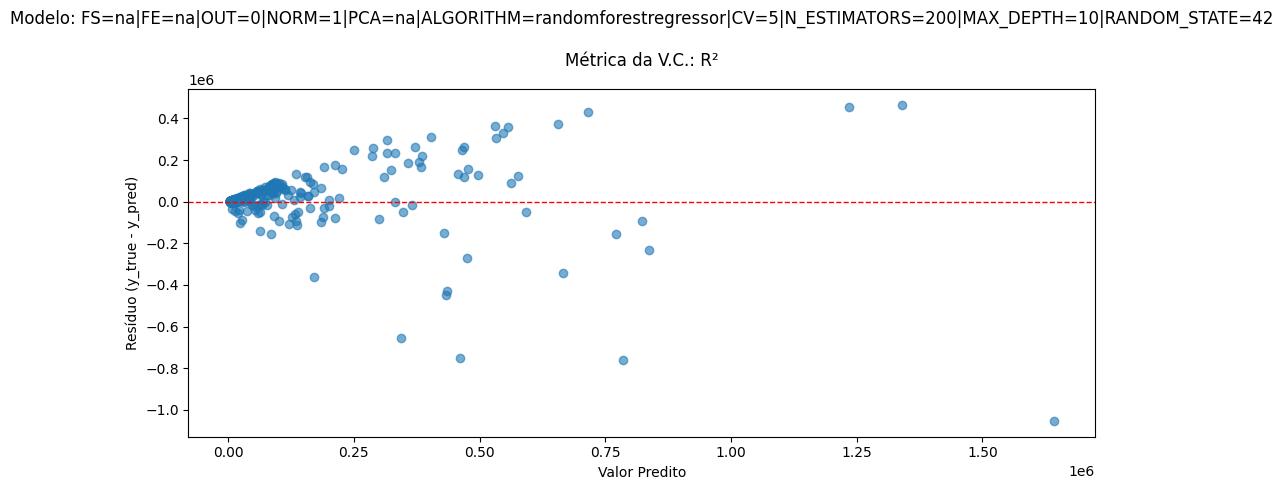

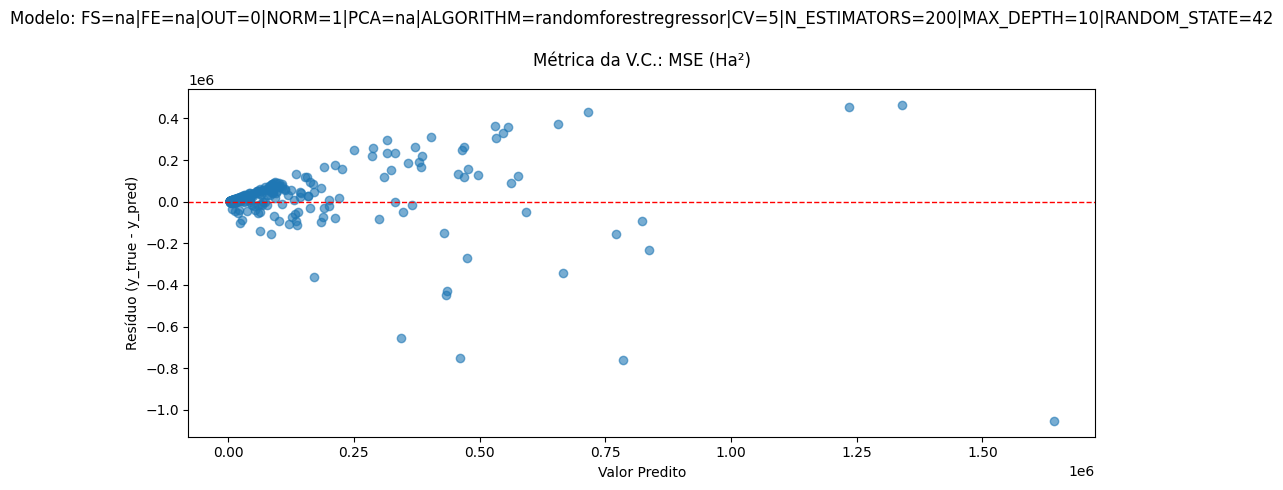

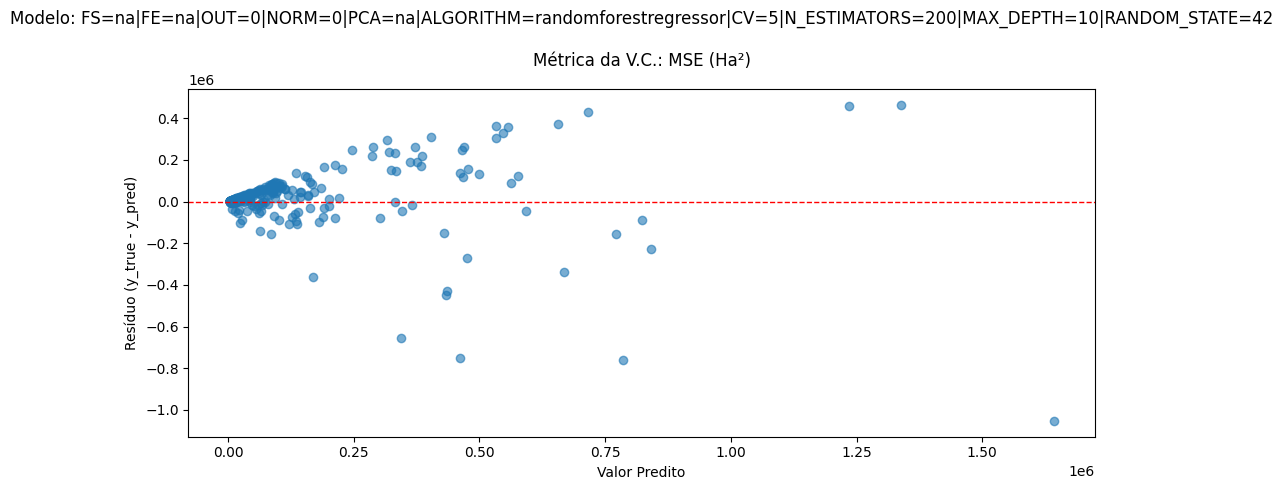

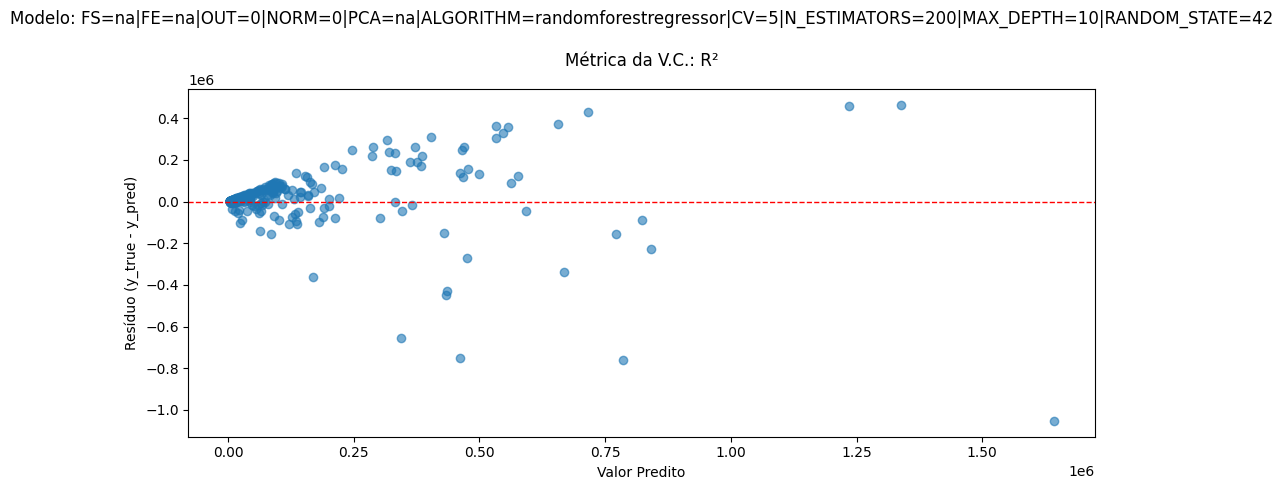

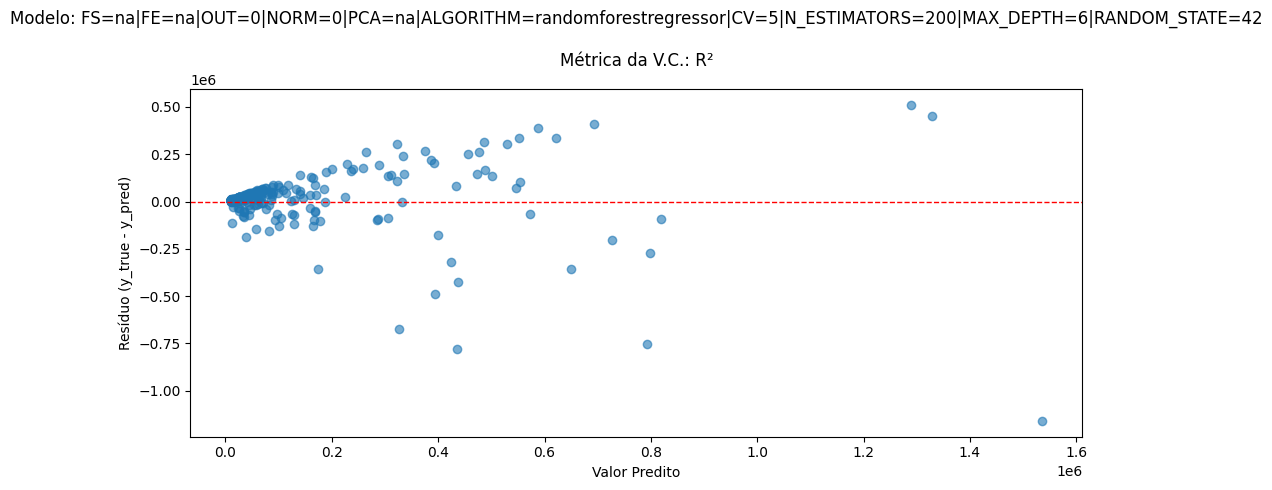

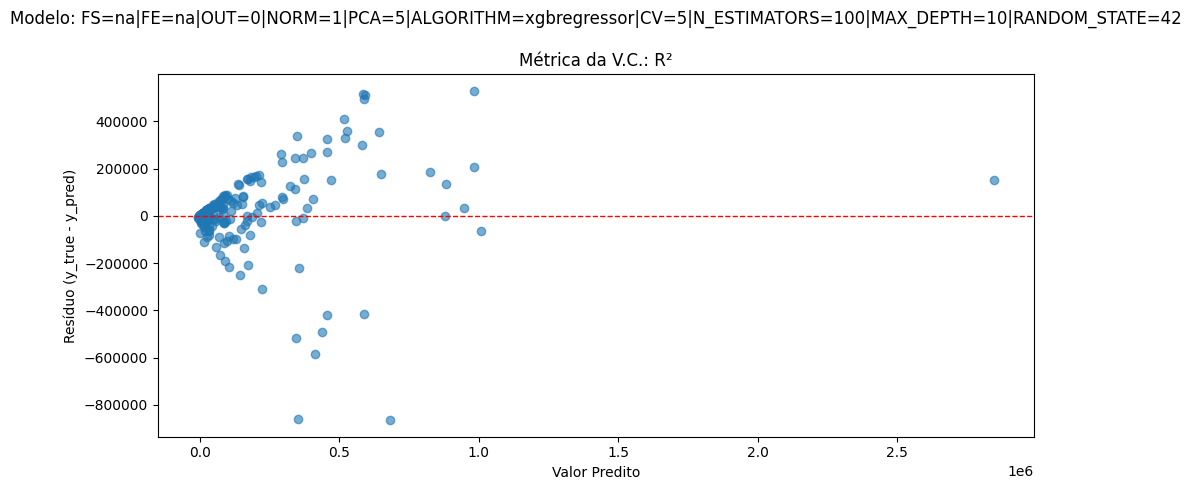

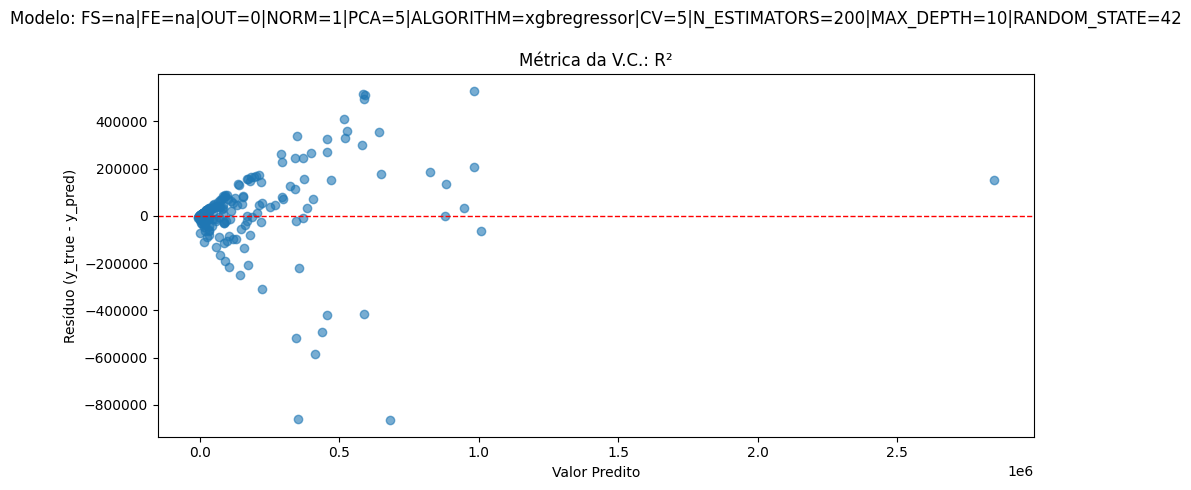

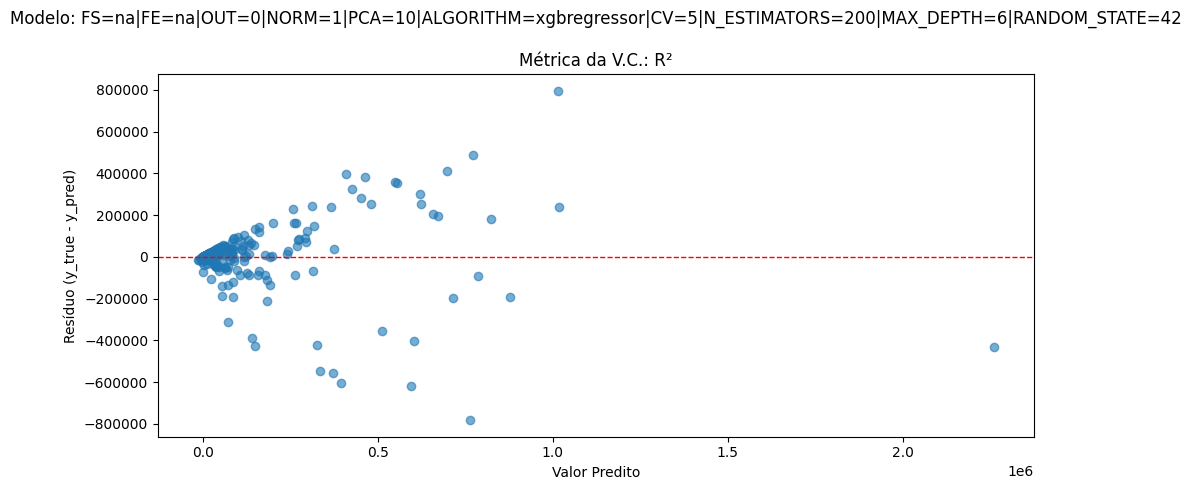

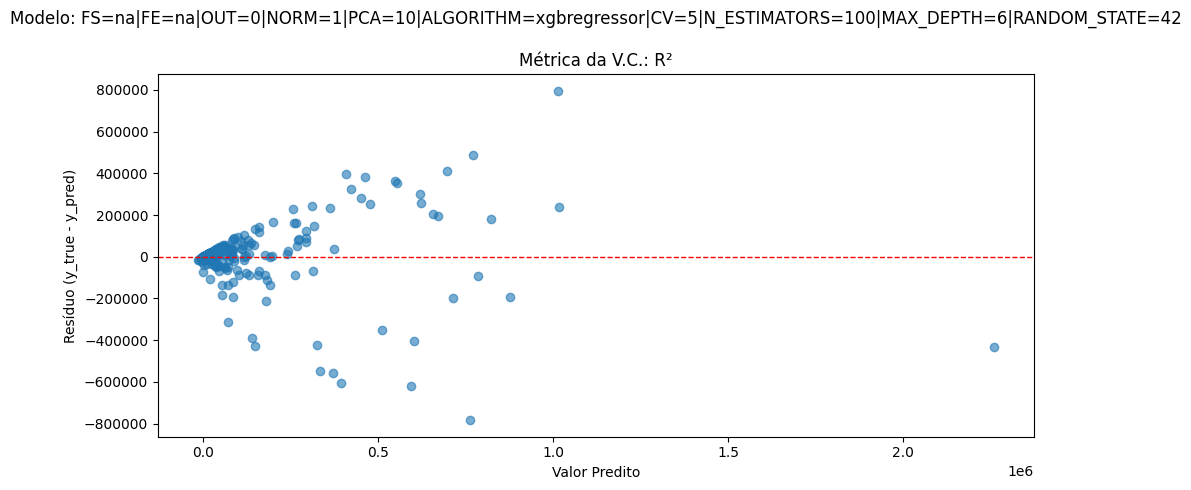

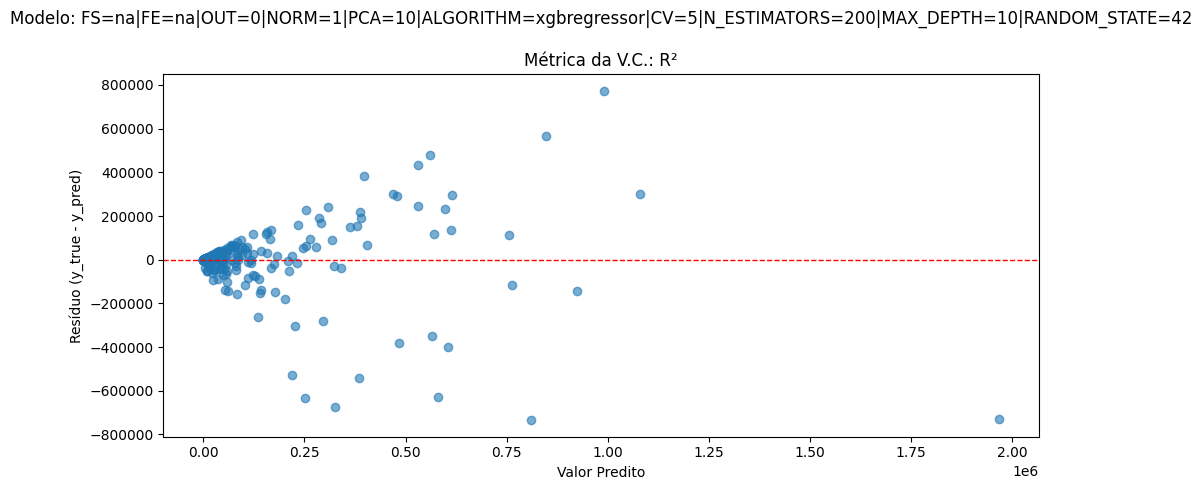

In [ ]:
# Formatação
bm.res_title = "Modelo: {cs}\n\nMétrica da V.C.: {cv_metric}"
bm.res_x_label = "Valor Predito"
bm.res_y_label = "Resíduo (y_true - y_pred)"

# Parâmetros
bm.random = 42
bm.common_params = {
    "df": bm.df_encoded,
    "target": "que_area_queimada",
    "random_state": bm.random,
    "features": [None],
    "test_size": 0.30,
    "metrics": exp.metrics,
}

# --- Obtém identificadores e dados do experimento dos melhores modelos ---

# -- RandomForest --
bm.df_rf = bm.df[bm.df[key.model] == exp.rf]
bm.df_cases_rf = bm.df_rf.head(bm.search_size)
bm.dict_exp_data_rf = get_experiment_data(
        **bm.common_params,
        col_selections =        [None],
        outliers =              [False],
        normalization =         [False, True],
        pcas =                  [0],
        model =                 RandomForestRegressor(),
        params = {
            "n_estimators":     [200],
            "max_depth":        [6, 10],
            "random_state":     [bm.random]
        },
        folds =                 [5],
)

# -- XGBoost --
bm.df_xgb = bm.df[bm.df[key.model] == exp.xgb]
bm.df_cases_xgb = bm.df_xgb.head(bm.search_size)
bm.dict_exp_data_xgb = get_experiment_data(
        **bm.common_params,
        col_selections =        [None],
        outliers =              [False],
        normalization =         [True],
        pcas =                  [5, 10],
        model =                 XGBRegressor(),
        params = {
            "n_estimators":     [100, 200],
            "max_depth":        [6, 10],
            "random_state":     [bm.random]
        },
        folds =                 [5],
)

# -- Análise de Resíduos --
bm.residue_map = {
    exp.rf: {
        "dict": bm.dict_exp_data_rf,
        "df": bm.df_cases_rf,
    },
    exp.xgb: {
        "dict": bm.dict_exp_data_xgb,
        "df": bm.df_cases_xgb,
    },
}

# Para cada algoritmo:
for model, model_data in bm.residue_map.items():
    # Obtém melhores casos
    best_cases = model_data["df"][key.cs].unique()

    # Para cada caso entre os melhores modelos:
    for cs in best_cases:
        # Obtém métricas usadas na validação cruzada para o caso em questão
        cs_data = model_data["df"][model_data["df"][key.cs] == cs]
        cv_metrics = cs_data[key.cv_metric].unique()

        for cv_metric in cv_metrics:
            try:
                # Recupera resíduos e valores preditos do melhor modelo segundo a métrica de validação cruzada em questão
                residuals = model_data["dict"][cs][_RESIDUAL][cv_metric]
                y_pred = model_data["dict"][cs][_PRED][cv_metric]

                # Exibe gráfico de resíduos
                plt.figure(figsize=(10,5))
                plt.scatter(y_pred,residuals, alpha=0.6)
                plt.axhline(0, color="red", linestyle="--", linewidth=1)
                plt.title(bm.res_title.format(cs=cs, cv_metric=fmt.map_metric[cv_metric]))
                plt.xlabel(bm.res_x_label)
                plt.ylabel(bm.res_y_label)
                plt.tight_layout()
                plt.show()

                print("\n") # Respiro visual

            except Exception as e:
                continue